In [1]:
from setup_notebook import setup_project_path
setup_project_path()

In [2]:
from src.config import RAW_DATA_DIR, PROCESSED_DATA_DIR, MODELS_DIR

In [3]:
import subprocess
import sys
import joblib
from sklearn.model_selection import RepeatedKFold, KFold, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error
import lightgbm
from lightgbm import LGBMRegressor
import pandas as pd
import argparse
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta
import numpy as np
import boto3
import gc
import datetime as dt
import io
from io import StringIO
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
data_dir = PROCESSED_DATA_DIR
model_dir = MODELS_DIR

os.makedirs(data_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

# OOV Evaluation

In [5]:
df_oot = pd.read_csv(os.path.join(data_dir,'KPIs_data_modelling_oot_validation_days.csv'))
df_oot = df_oot[df_oot.backtesting>=360]
model = lightgbm.Booster(model_file = os.path.join(model_dir,'lgbm_cbr_model_2025-09-23.txt'))

In [6]:
a = df_oot[df_oot.columns]
a[a.accounts_group.str.contains('2022-06_Kenya_Lanterns_Kakamega_Sun King Pro EasyBuy')].drop(['accounts_group','count_units','frr_3_years','total_follow_on_revenue_usd',
                       'reg_month','country','product_group','area','primary_product','actual_fr'], axis=1).sort_values(by="backtesting").T

,451,188161,186483,14941,194196
avg_planned_repayment_days,368.000000,368.000000,368.000000,368.000000,368.000000
backtesting,360.000000,450.000000,540.000000,630.000000,720.000000
frr,0.672563,0.756341,0.800177,0.829860,0.851869
repayment_speed,0.687600,0.756300,0.800100,0.829800,0.851800
avg_cum_days_disabled,87.000000,117.000000,146.000000,167.000000,185.000000
at_risk_rate,0.034483,0.055556,0.068966,0.076923,0.125000
disabled_gt_two_week_rate,0.166667,0.100000,0.216667,0.200000,0.166667
unlocked_rate,0.033333,0.400000,0.516667,0.566667,0.633333
disabled_rate,0.416667,0.400000,0.366667,0.333333,0.233333
avg_upfront_price_usd,3.000000,3.000000,3.000000,3.000000,3.000000


In [7]:
df_oot.iloc[0].accounts_group

'2022-06_Kenya_Lanterns_Olkalau_Sun King Pro EasyBuy'

In [8]:
df_oot['backtesting'].value_counts()

backtesting
540    20151
630    20151
360    20151
450    20151
720    20151
Name: count, dtype: int64

In [9]:
X_oot = df_oot.drop(['accounts_group','count_units','frr_3_years','total_follow_on_revenue_usd',
                       'reg_month','country','product_group','area','primary_product','actual_fr'], axis=1)
y_oot = df_oot[:]['frr_3_years']

print('shape of the input data: ',X_oot.shape)
print('shape of the output data: ',y_oot.shape)

shape of the input data:  (100755, 11)
shape of the output data:  (100755,)


In [10]:
X_oot.head()

,avg_planned_repayment_days,backtesting,frr,repayment_speed,avg_cum_days_disabled,at_risk_rate,disabled_gt_two_week_rate,unlocked_rate,disabled_rate,avg_upfront_price_usd,avg_unlock_price_usd
1,368,540,0.880822,0.8808,142.0,0.000000,0.000000,0.750000,0.000000,3.0,50.0
2,365,630,0.780187,0.7801,218.0,0.032787,0.183206,0.519084,0.366412,14.0,202.0
8,598,630,0.282593,0.2825,291.0,0.000000,1.000000,0.000000,1.000000,15.0,732.0
10,367,540,0.854328,0.8543,157.0,0.000000,0.093750,0.484375,0.296875,26.0,199.0
11,637,540,0.608830,0.7196,157.0,0.000000,0.000000,0.000000,0.428571,11.0,538.0


In [11]:
y_pred_oot = model.predict(X_oot)

X_oot_copy = df_oot.copy()
X_oot_copy['actual_frr'] = y_oot
X_oot_copy['predicted_frr'] = y_pred_oot

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_pinball_loss
import math
results = {
    "rmse": math.sqrt(mean_squared_error(y_oot,y_pred_oot)),
    "mae": mean_absolute_error(y_oot, y_pred_oot),
    "mape": np.mean(np.abs((y_oot - y_pred_oot) / y_oot)),
    "r2": r2_score(y_oot, y_pred_oot),
    "qloss":  mean_pinball_loss(y_oot, y_pred_oot, alpha=0.5)
}

results

{'rmse': 0.05507849994973997,
 'mae': 0.029597667693294794,
 'mape': 0.05265938271230739,
 'r2': 0.8870179350135906,
 'qloss': 0.014798833846647397}

In [13]:
X_oot_copy["predicted_frr"]  = X_oot_copy["predicted_frr"].clip(lower=0, upper=1)
X_oot_copy["frr_3_years"]  = X_oot_copy["frr_3_years"].clip(lower=0, upper=1)
X_oot_copy['predicted_revenue_USD'] = np.round(X_oot_copy['predicted_frr']*X_oot_copy['total_follow_on_revenue_usd'],2)

In [14]:
X_oot_copy.head()

,accounts_group,count_units,avg_planned_repayment_days,frr_3_years,actual_fr,total_follow_on_revenue_usd,reg_month,country,product_group,area,...,avg_cum_days_disabled,at_risk_rate,disabled_gt_two_week_rate,unlocked_rate,disabled_rate,avg_upfront_price_usd,avg_unlock_price_usd,actual_frr,predicted_frr,predicted_revenue_USD
1,2022-06_Kenya_Lanterns_Olkalau_Sun King Pro Ea...,4,368,0.935388,174.600736,186.661296,2022-06,Kenya,Lanterns,Olkalau,...,142.0,0.000000,0.000000,0.750000,0.000000,3.0,50.0,0.935388,0.954395,178.15
2,2022-04_Kenya_SHS Entry-Level_Mandera_Sun King...,131,365,0.854693,21057.981777,24638.065103,2022-04,Kenya,SHS Entry-Level,Mandera,...,218.0,0.032787,0.183206,0.519084,0.366412,14.0,202.0,0.854693,0.852578,21005.87
8,2022-05_Tanzania_SHS with TV Upgrade_Tanga_Sun...,1,598,0.282593,202.465831,716.457348,2022-05,Tanzania,SHS with TV Upgrade,Tanga,...,291.0,0.000000,1.000000,0.000000,1.000000,15.0,732.0,0.282593,0.373128,267.33
10,2022-04_Kenya_Phones_Garsen_Samsung A03 Core,64,367,0.944940,10485.469288,11096.439232,2022-04,Kenya,Phones,Garsen,...,157.0,0.000000,0.093750,0.484375,0.296875,26.0,199.0,0.944940,0.955772,10605.67
11,2022-03_Kenya_SHS with TV Upgrade_Luanda_Sun K...,7,637,0.859382,3171.226057,3690.123900,2022-03,Kenya,SHS with TV Upgrade,Luanda,...,157.0,0.000000,0.000000,0.000000,0.428571,11.0,538.0,0.859382,0.882674,3257.18


In [15]:
X_oot_copy.iloc[0].accounts_group

'2022-06_Kenya_Lanterns_Olkalau_Sun King Pro EasyBuy'

In [16]:
X_oot_copy[X_oot_copy.accounts_group.str.contains('2022-06_Kenya_SHS Entry-Level Upgrade_Kwale_Sun King Home 60 EasyBuy')].T

,11971,26689,60023,76969,186213
accounts_group,2022-06_Kenya_SHS Entry-Level Upgrade_Kwale_Su...,2022-06_Kenya_SHS Entry-Level Upgrade_Kwale_Su...,2022-06_Kenya_SHS Entry-Level Upgrade_Kwale_Su...,2022-06_Kenya_SHS Entry-Level Upgrade_Kwale_Su...,2022-06_Kenya_SHS Entry-Level Upgrade_Kwale_Su...
count_units,6,6,6,6,6
avg_planned_repayment_days,371,371,371,371,371
frr_3_years,0.876426,0.876426,0.876426,0.876426,0.876426
actual_fr,571.013129,571.013129,571.013129,571.013129,571.013129
total_follow_on_revenue_usd,651.524634,651.524634,651.524634,651.524634,651.524634
reg_month,2022-06,2022-06,2022-06,2022-06,2022-06
country,Kenya,Kenya,Kenya,Kenya,Kenya
product_group,SHS Entry-Level Upgrade,SHS Entry-Level Upgrade,SHS Entry-Level Upgrade,SHS Entry-Level Upgrade,SHS Entry-Level Upgrade
area,Kwale,Kwale,Kwale,Kwale,Kwale


In [17]:
X_oot_copy[X_oot_copy.accounts_group=='2022-03_Kenya_Lanterns_Kakamega_Sun King Boom EasyBuy'].T

,8086,50253,74309,91831,136237
accounts_group,2022-03_Kenya_Lanterns_Kakamega_Sun King Boom ...,2022-03_Kenya_Lanterns_Kakamega_Sun King Boom ...,2022-03_Kenya_Lanterns_Kakamega_Sun King Boom ...,2022-03_Kenya_Lanterns_Kakamega_Sun King Boom ...,2022-03_Kenya_Lanterns_Kakamega_Sun King Boom ...
count_units,1205,1205,1205,1205,1205
avg_planned_repayment_days,323,323,323,323,323
frr_3_years,0.917986,0.917986,0.917986,0.917986,0.917986
actual_fr,60928.612016,60928.612016,60928.612016,60928.612016,60928.612016
total_follow_on_revenue_usd,66372.049264,66372.049264,66372.049264,66372.049264,66372.049264
reg_month,2022-03,2022-03,2022-03,2022-03,2022-03
country,Kenya,Kenya,Kenya,Kenya,Kenya
product_group,Lanterns,Lanterns,Lanterns,Lanterns,Lanterns
area,Kakamega,Kakamega,Kakamega,Kakamega,Kakamega


In [18]:
df_country = X_oot_copy.groupby(["reg_month", "country", 'backtesting']).agg(
    total_fr=('actual_fr', "sum"),
    total_follow_on_price=('total_follow_on_revenue_usd', "sum"),
    total_predicted_fr=('predicted_revenue_USD', 'sum')
).reset_index()
df_country["actual_frr"] = np.round(df_country.total_fr/df_country.total_follow_on_price,4)
df_country["predicted_frr"] = np.round(df_country.total_predicted_fr/df_country.total_follow_on_price,4)
df_country["deviation"] = (df_country.predicted_frr - df_country.actual_frr).round(4)

In [19]:
countries = ['Kenya','Nigeria','Tanzania','Uganda','Zambia']
product_list = ['Lanterns', 'SHS with TV', 'SHS without TV', 'SHS Entry-Level']
list_backtesting = [360, 450, 540, 630, 720]

## OOV Stats per Country

In [20]:
df_country[df_country.country.isin(countries)].groupby("country").deviation.describe().reset_index()

,country,count,mean,std,min,25%,50%,75%,max
0,Kenya,30.0,0.003893,0.003839,-0.0051,0.001175,0.00455,0.007025,0.0102
1,Nigeria,30.0,-0.003303,0.001580,-0.0064,-0.004625,-0.00310,-0.002350,0.0003
2,Tanzania,30.0,0.014227,0.005462,0.0060,0.010100,0.01485,0.018025,0.0264
3,Uganda,30.0,0.016290,0.006104,0.0054,0.010700,0.01745,0.020300,0.0288
4,Zambia,30.0,-0.003557,0.005589,-0.0147,-0.006675,-0.00375,-0.001100,0.0109


## OOV Line Graph per Country

-0.0001


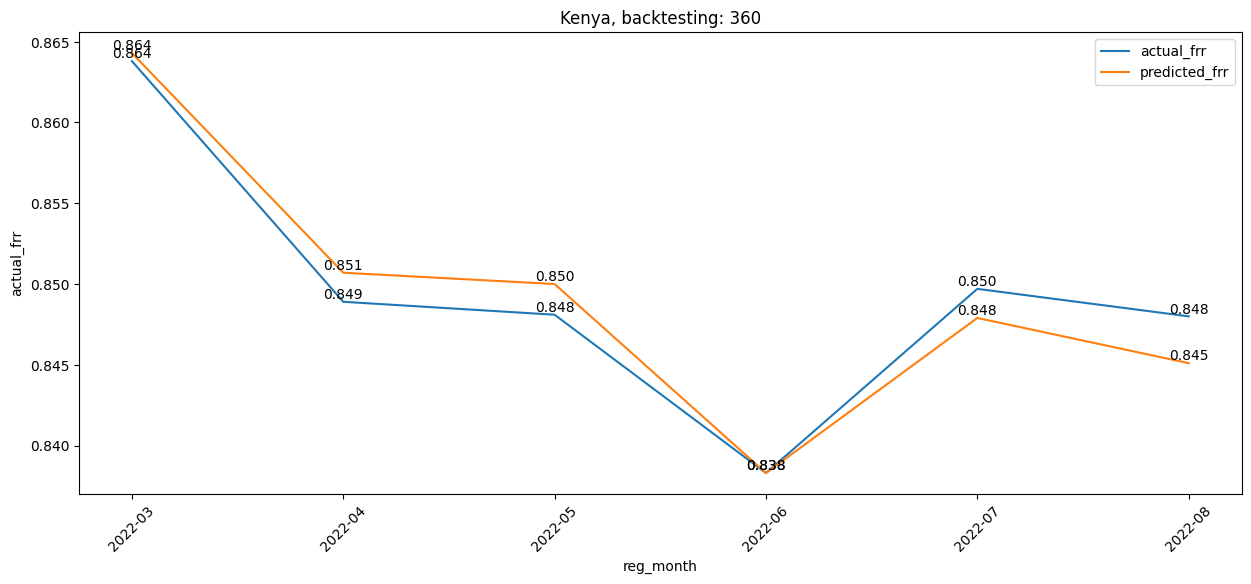

0.0008


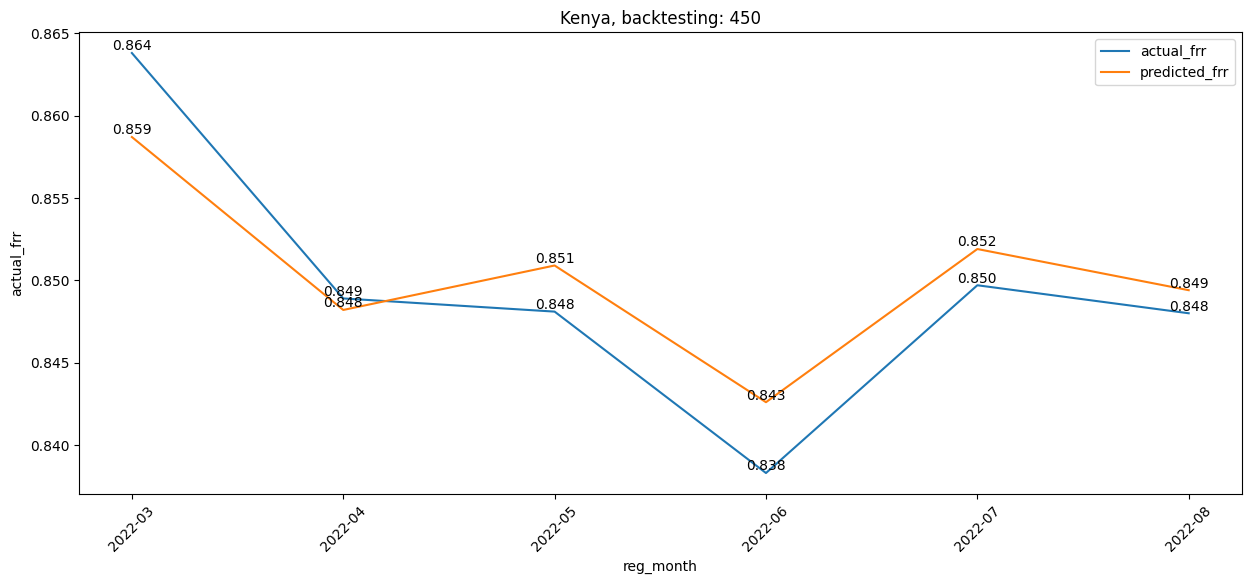

0.0055


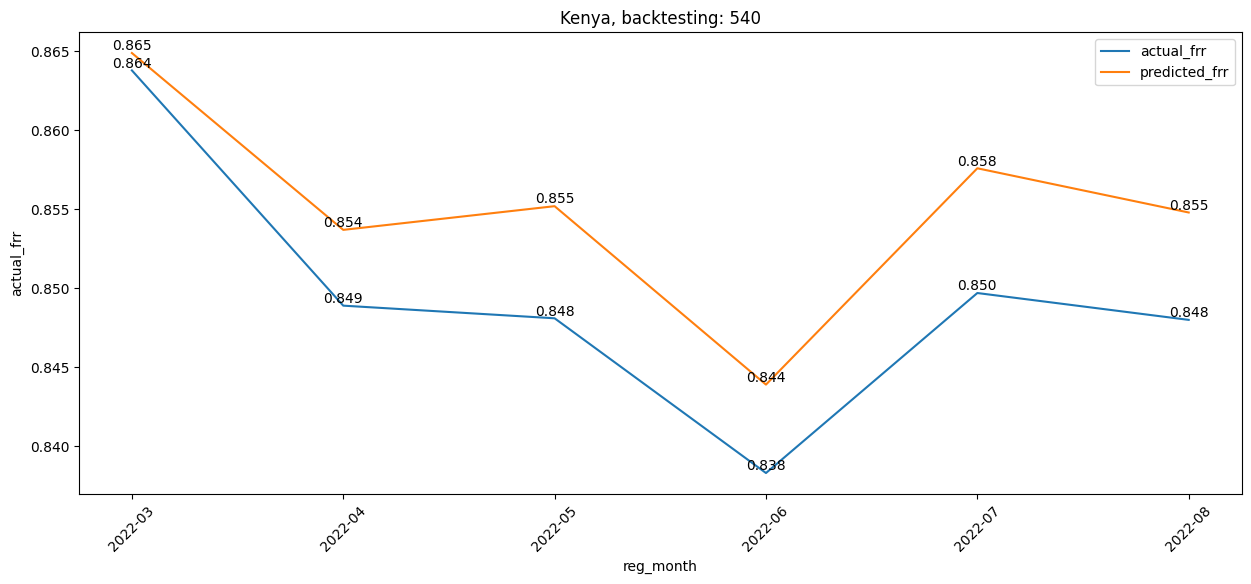

0.0054


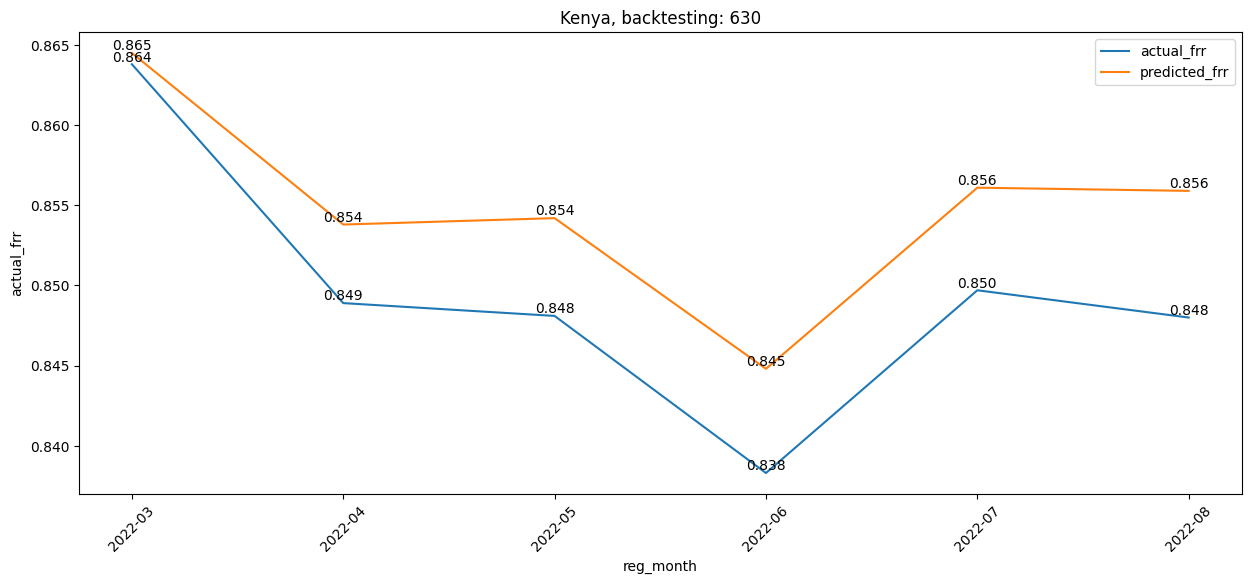

0.0078


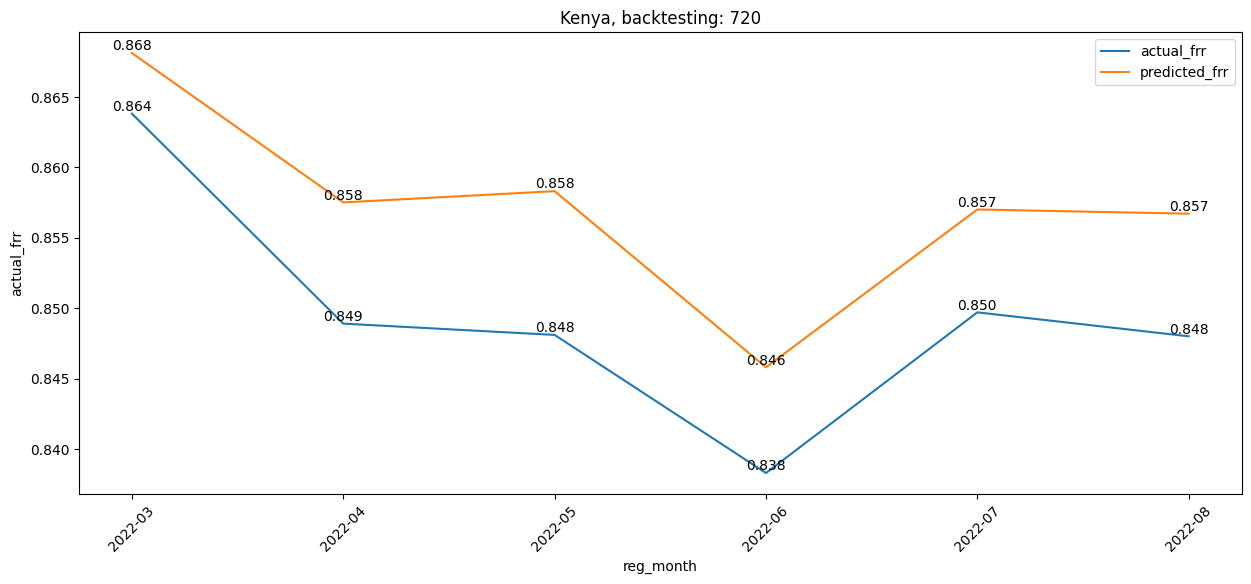

-0.0039


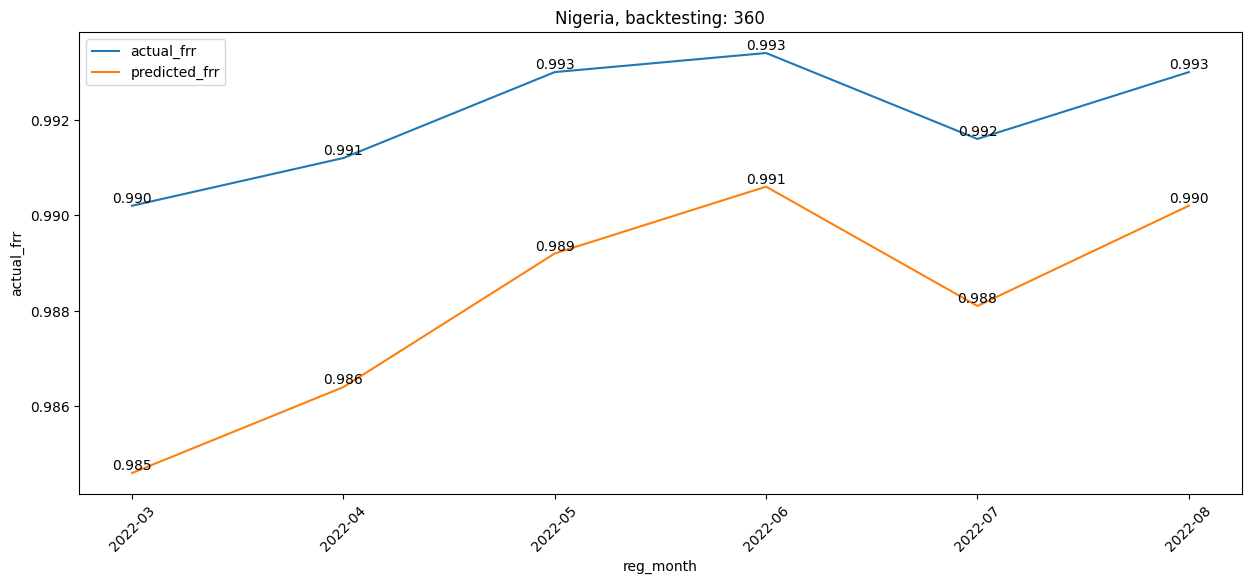

-0.005


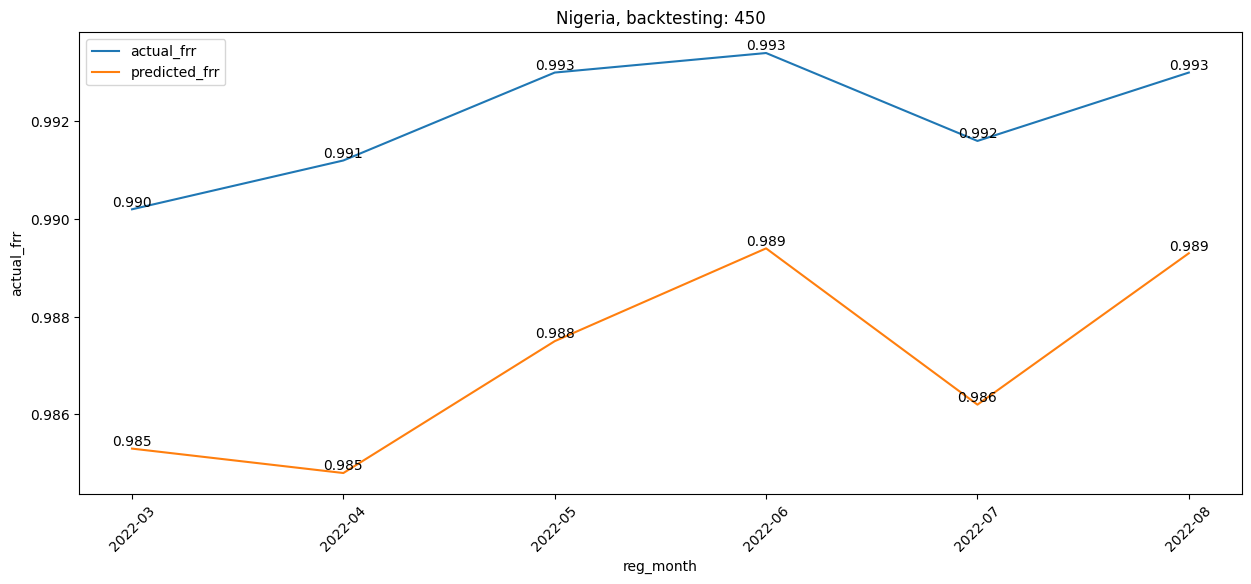

-0.0038


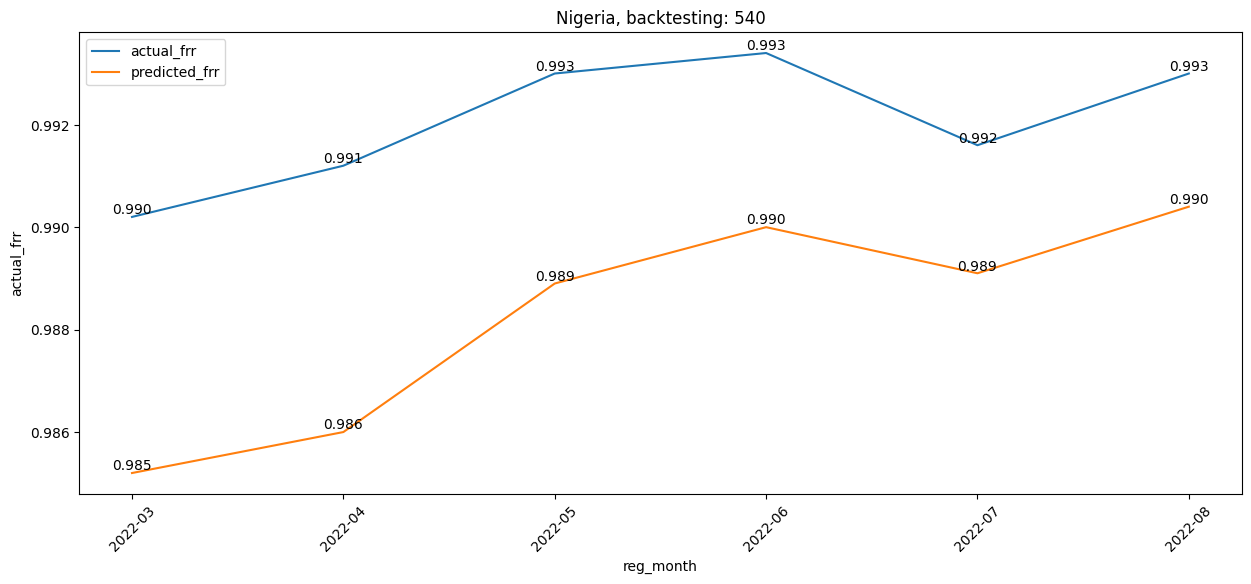

-0.0014


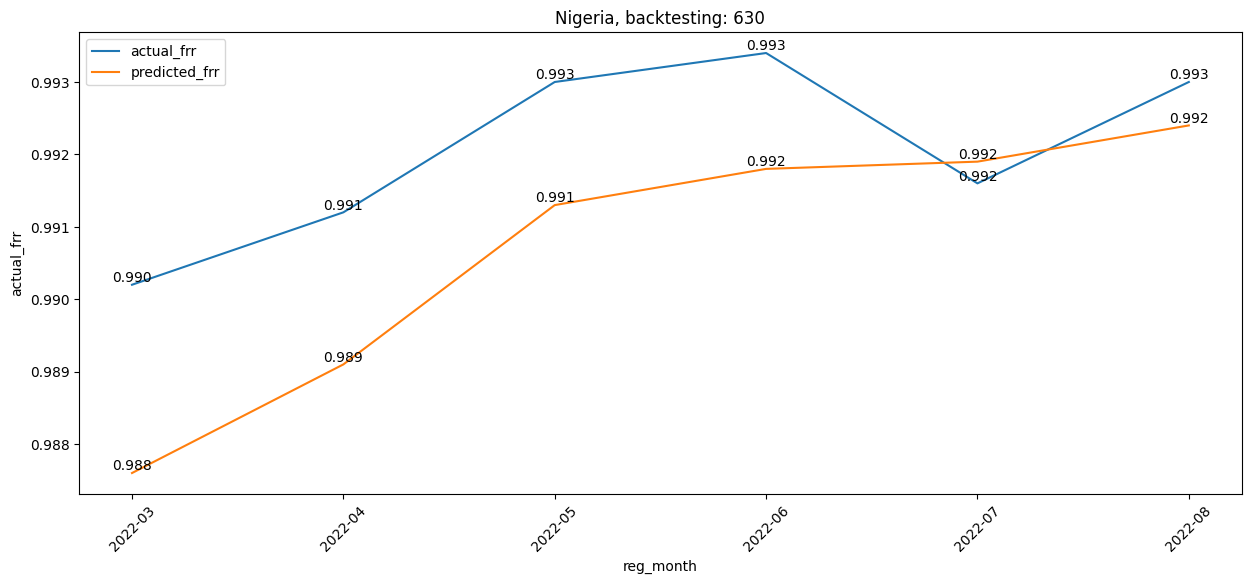

-0.0025


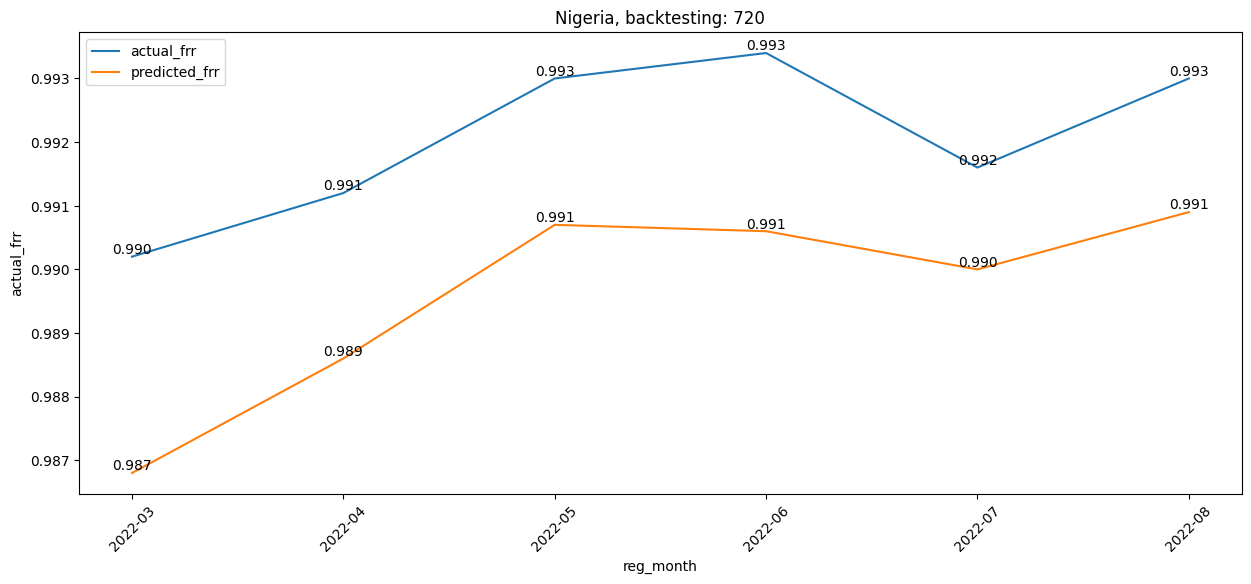

0.0153


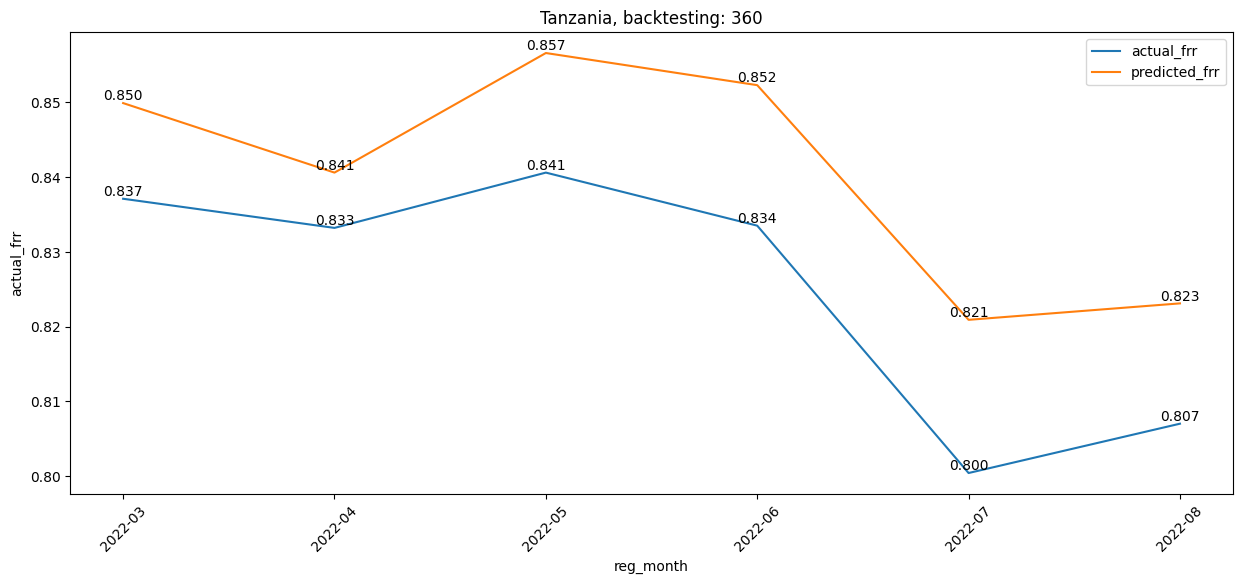

0.0163


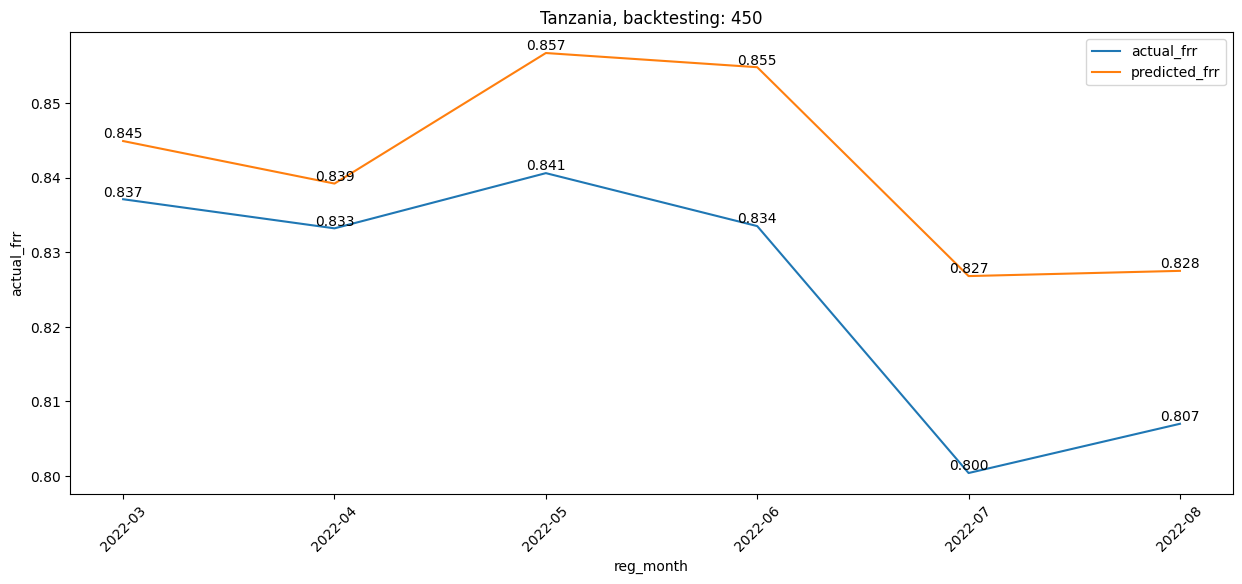

0.0166


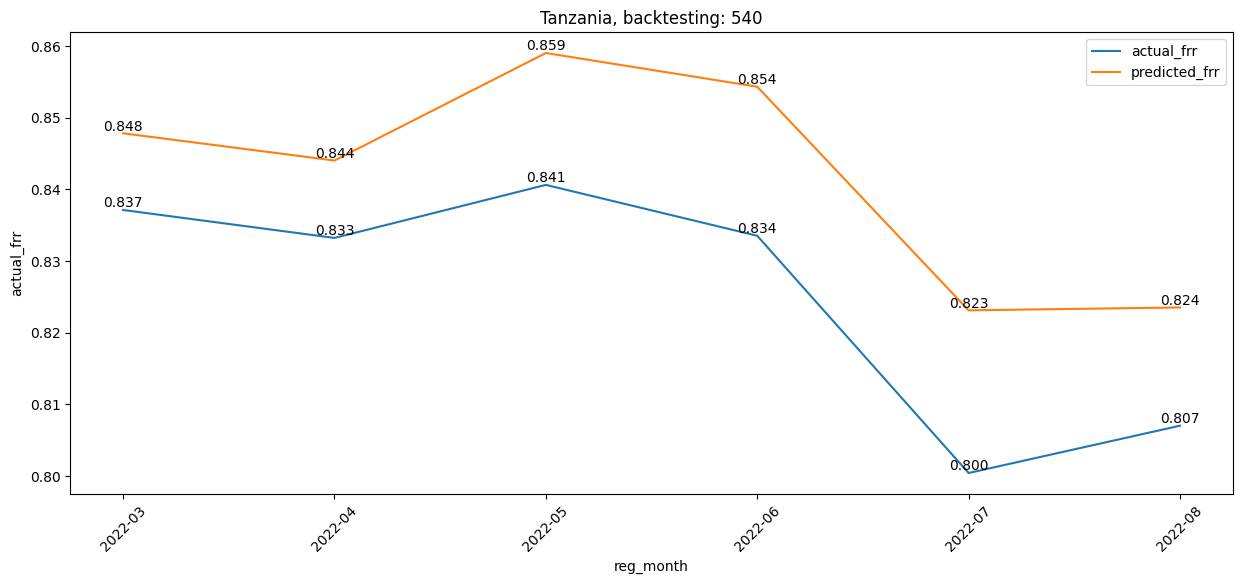

0.0141


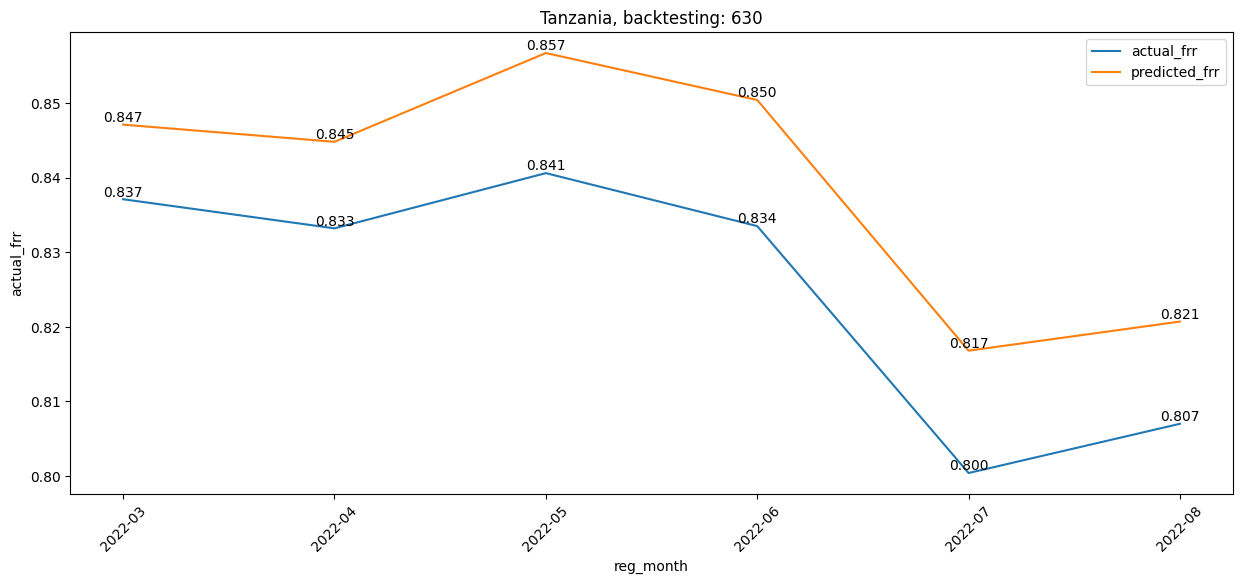

0.0087


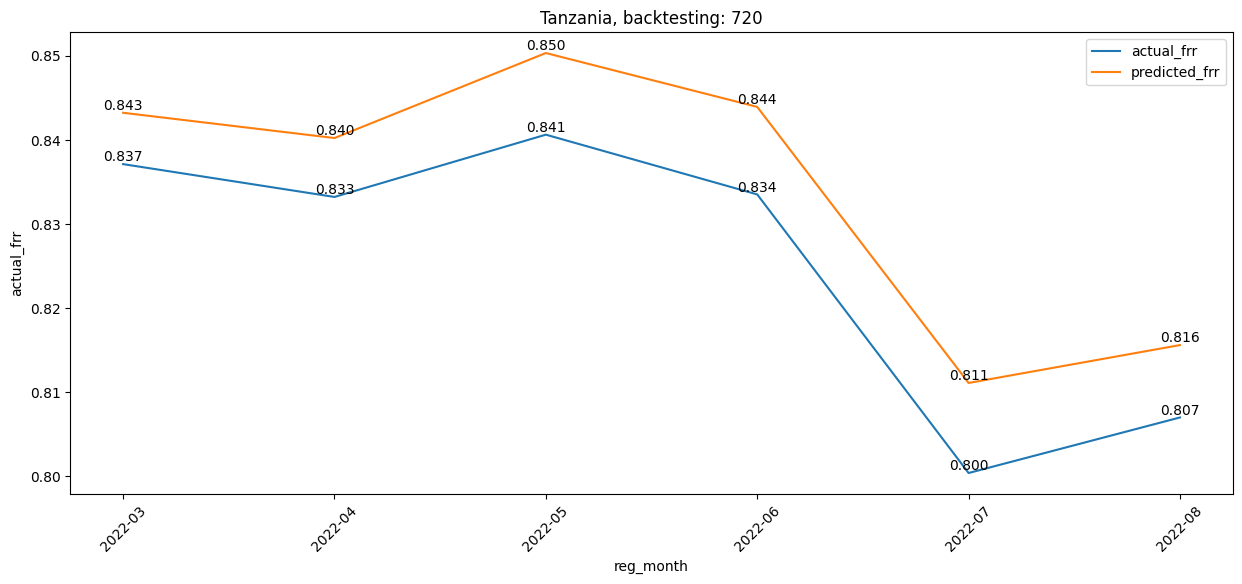

0.0234


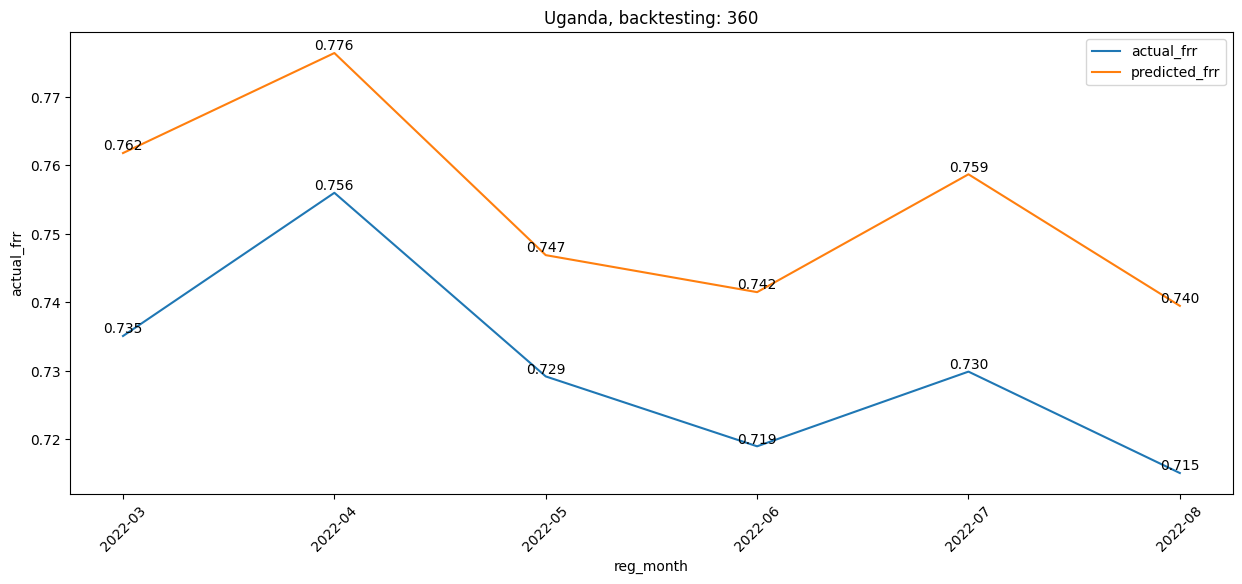

0.0183


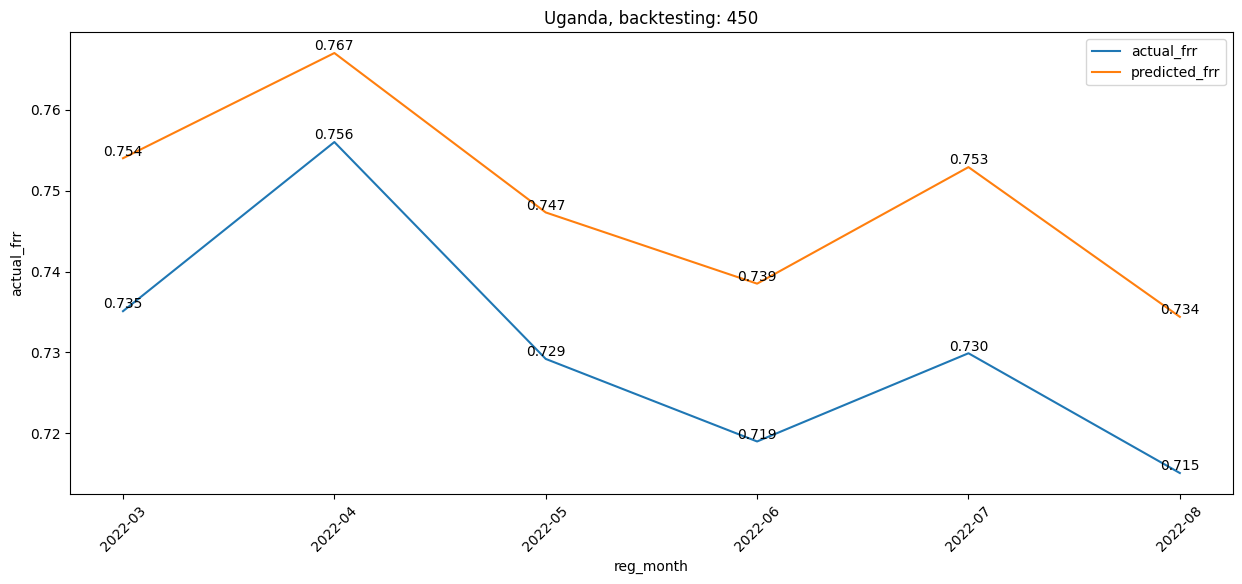

0.016


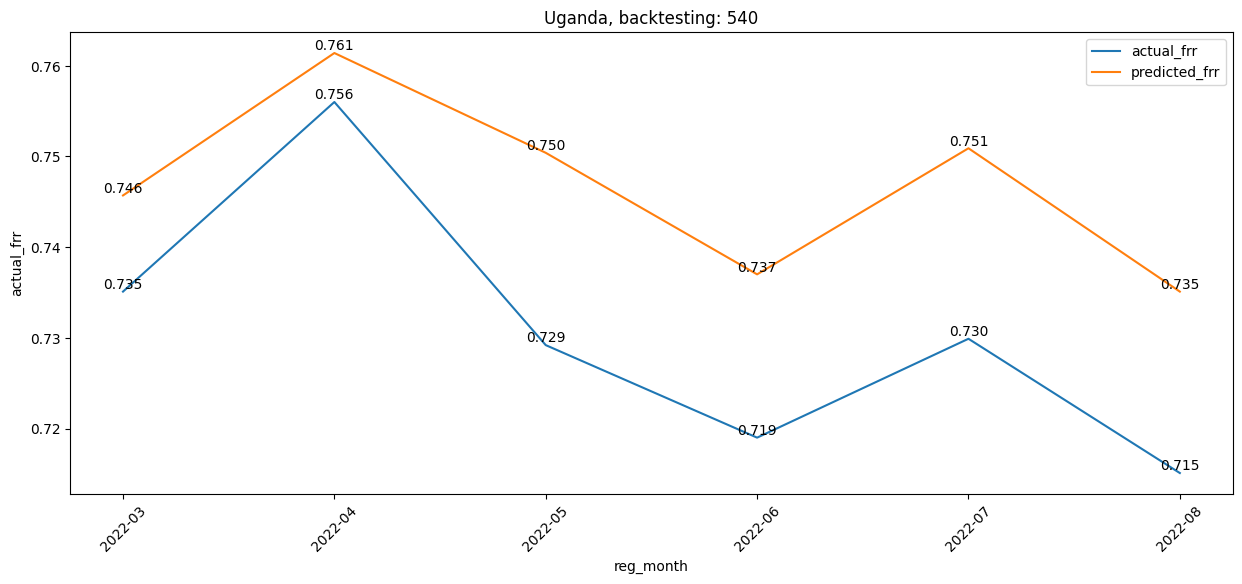

0.0141


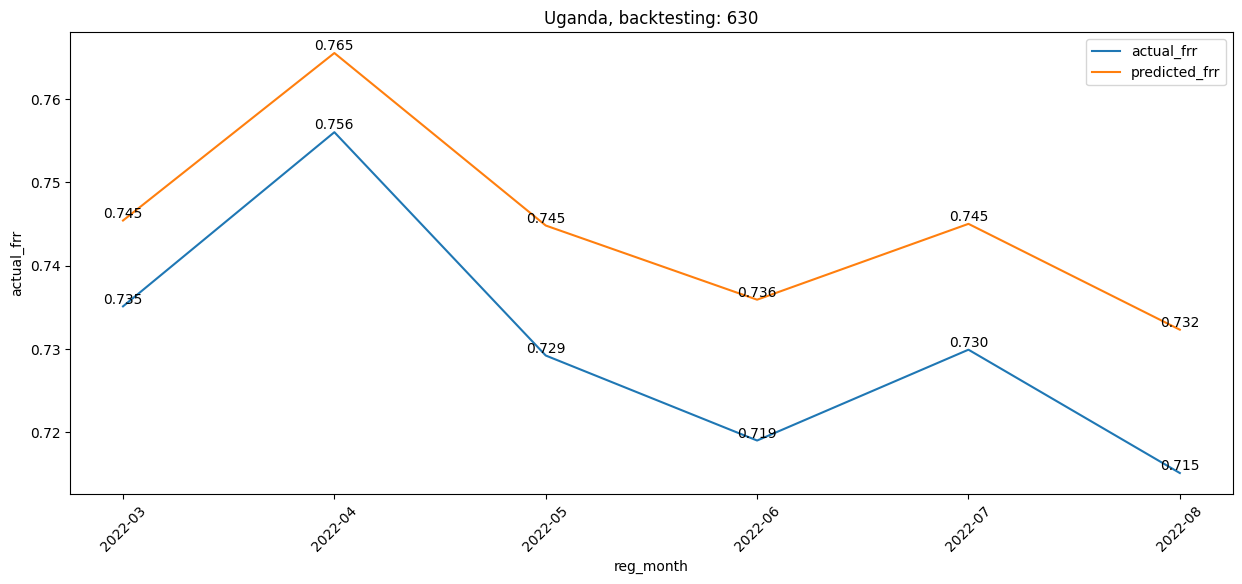

0.0096


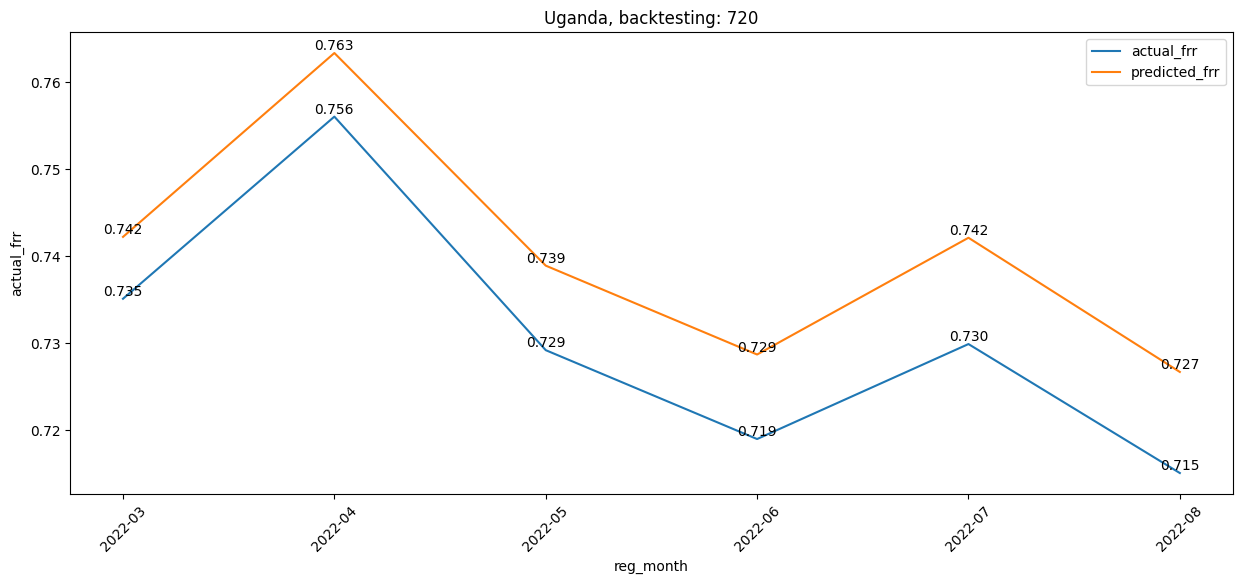

-0.0


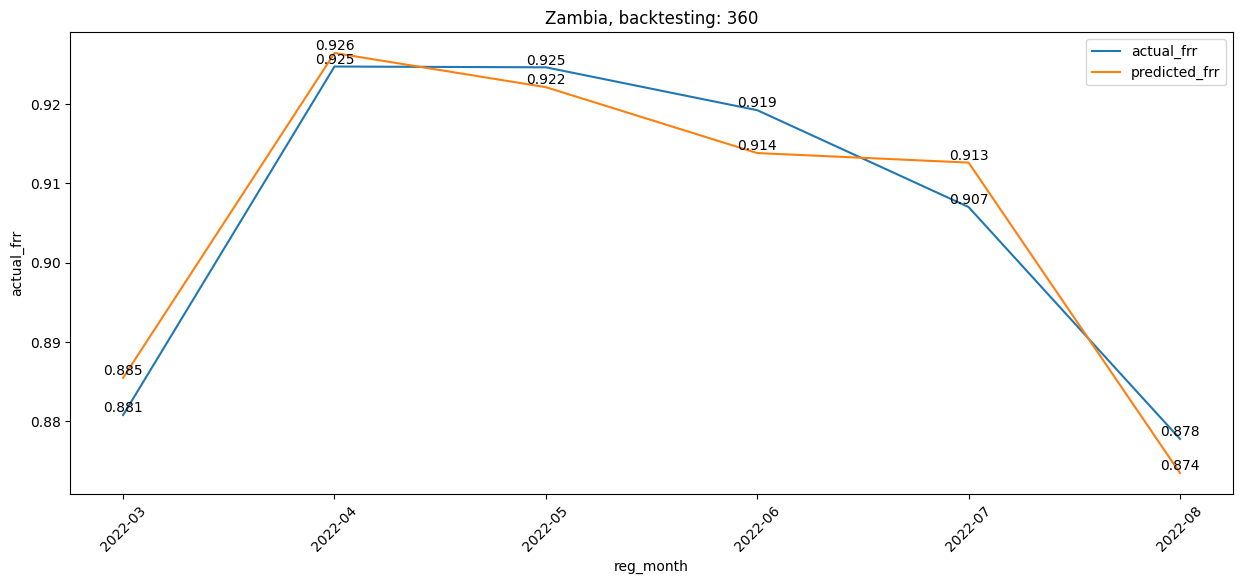

-0.0035


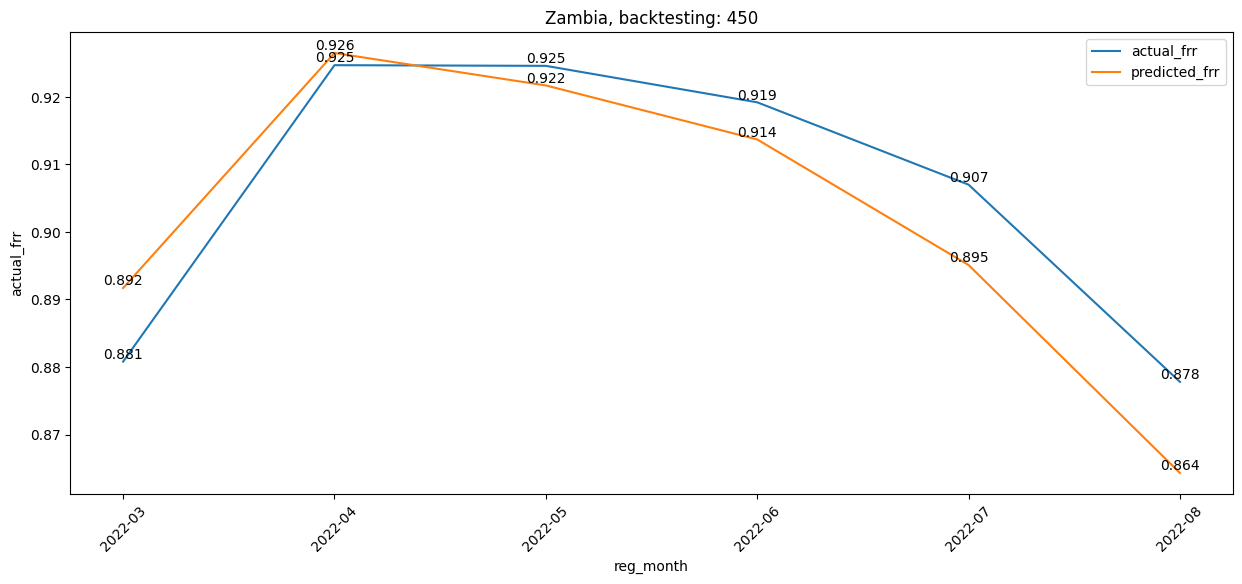

-0.0059


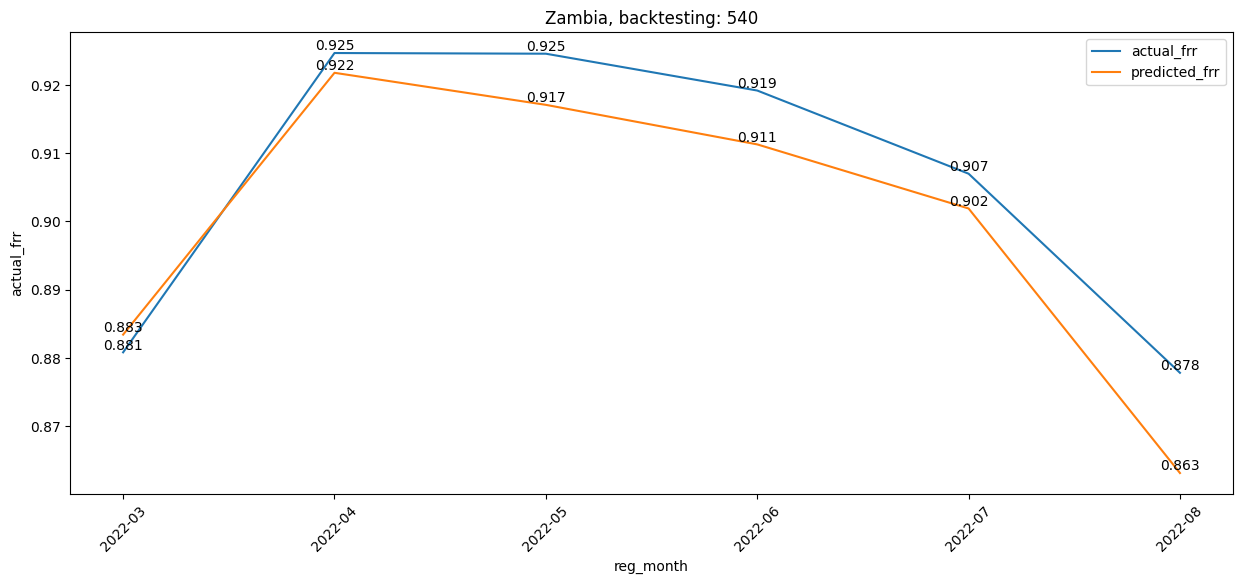

-0.0053


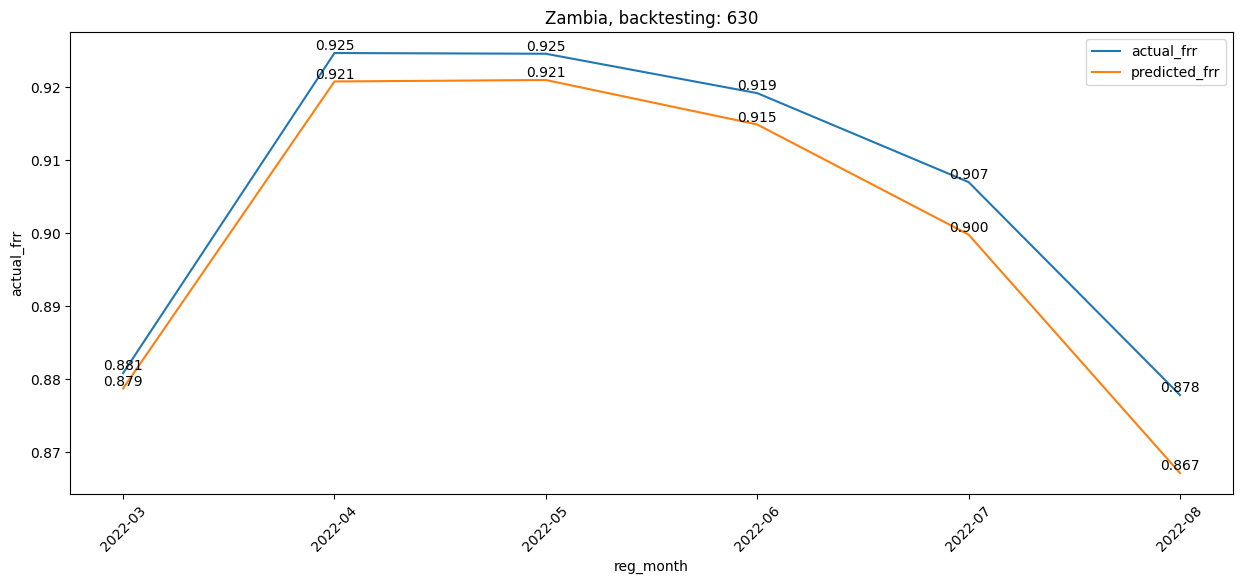

-0.003


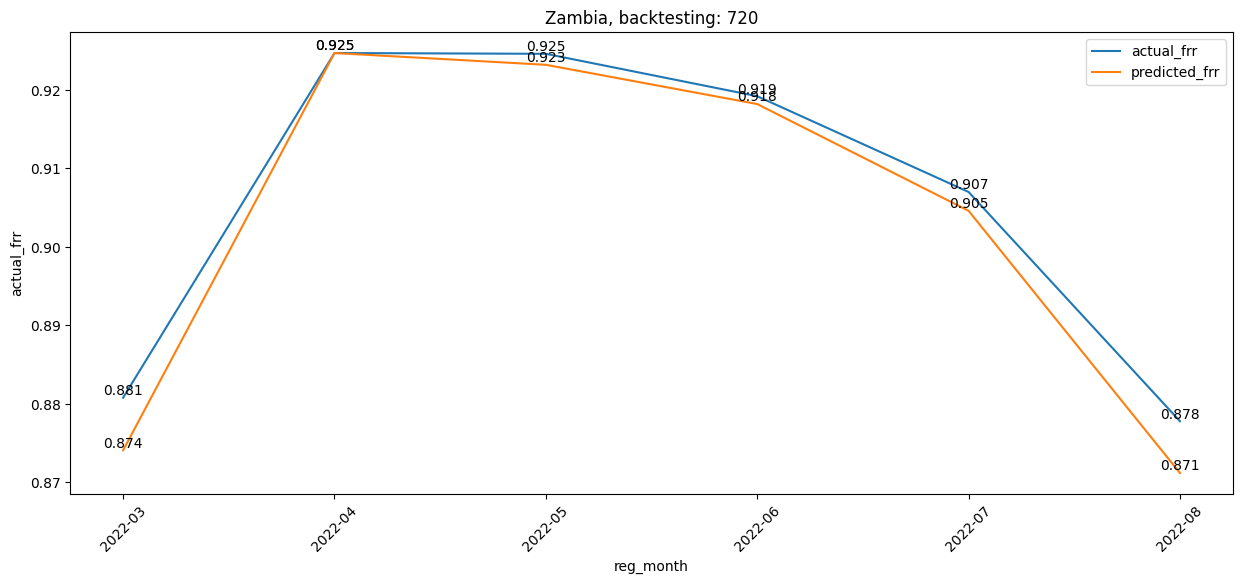

In [21]:
for country in countries:
    for backtesting in list_backtesting:
        plt.figure(figsize=(15, 6))
        subset = df_country[(df_country.country==country) & (df_country.backtesting==backtesting)]
        deviation = (subset.predicted_frr - subset.actual_frr).mean().round(4)
        print(deviation)
        ax = sns.lineplot(data=subset, x="reg_month", y="actual_frr", label="actual_frr")
        for x, y in zip(subset["reg_month"], subset["actual_frr"]):
            ax.text(x, y, f"{y:.3f}", ha="center", va="bottom")
        
        ax = sns.lineplot(data=subset, x="reg_month", y="predicted_frr", label="predicted_frr")
        for x, y in zip(subset["reg_month"], subset["predicted_frr"]):
            ax.text(x, y, f"{y:.3f}", ha="center", va="bottom")
        # sns.lineplot(data=df2, x="reg_month", y="frr_prediction_50")
        plt.xticks(rotation=45)
        plt.title(f"{country}, backtesting: {backtesting}")
        plt.legend()
        plt.show()

## OOV Per Product

In [22]:
df_product = X_oot_copy.groupby(["reg_month", "product_group", 'backtesting']).agg(
    total_fr=('actual_fr', "sum"),
    total_follow_on_price=('total_follow_on_revenue_usd', "sum"),
    total_predicted_fr=('predicted_revenue_USD', 'sum')
).reset_index()
df_product["actual_frr"] = np.round(df_product.total_fr/df_product.total_follow_on_price,4)
df_product["predicted_frr"] = np.round(df_product.total_predicted_fr/df_product.total_follow_on_price,4)
df_product["deviation"] = (df_product.predicted_frr - df_product.actual_frr).round(4)

In [23]:
df_product[df_product.product_group.isin(product_list)].groupby("product_group").deviation.describe().reset_index()

,product_group,count,mean,std,min,25%,50%,75%,max
0,Lanterns,30.0,-0.001087,0.008616,-0.0204,-0.003575,0.00155,0.003475,0.0096
1,SHS Entry-Level,30.0,0.001897,0.001600,-0.0012,0.000750,0.00210,0.002800,0.0054
2,SHS with TV,30.0,-0.001923,0.003676,-0.0084,-0.005325,-0.00180,0.000875,0.0042
3,SHS without TV,30.0,-0.012220,0.004972,-0.0241,-0.015325,-0.01225,-0.008450,-0.0042


-0.0148


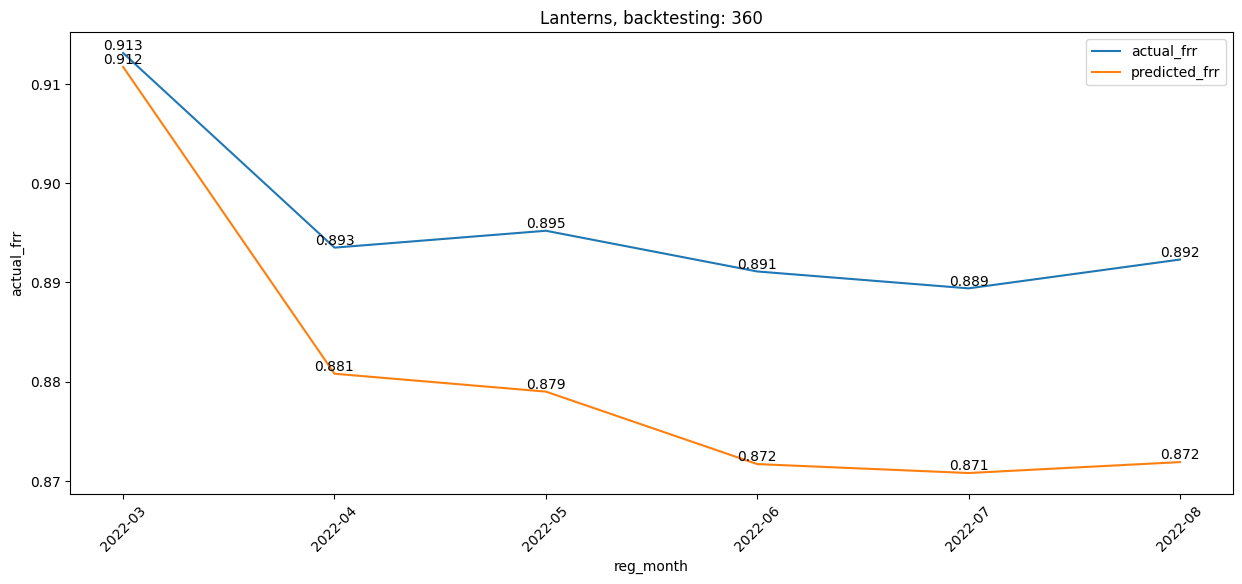

-0.0039


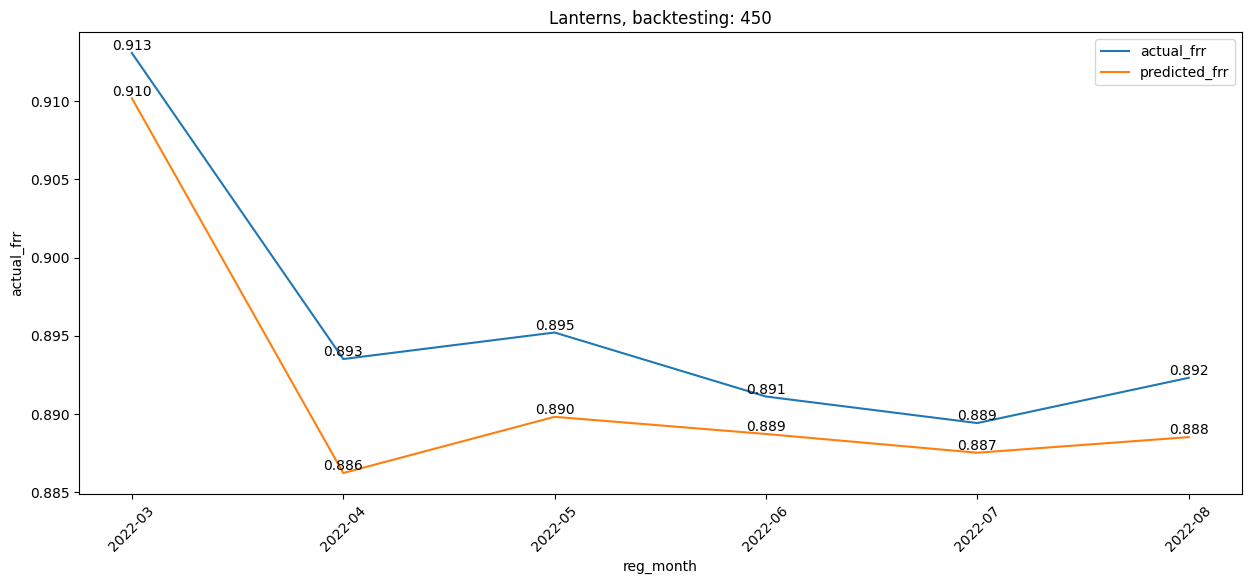

0.0028


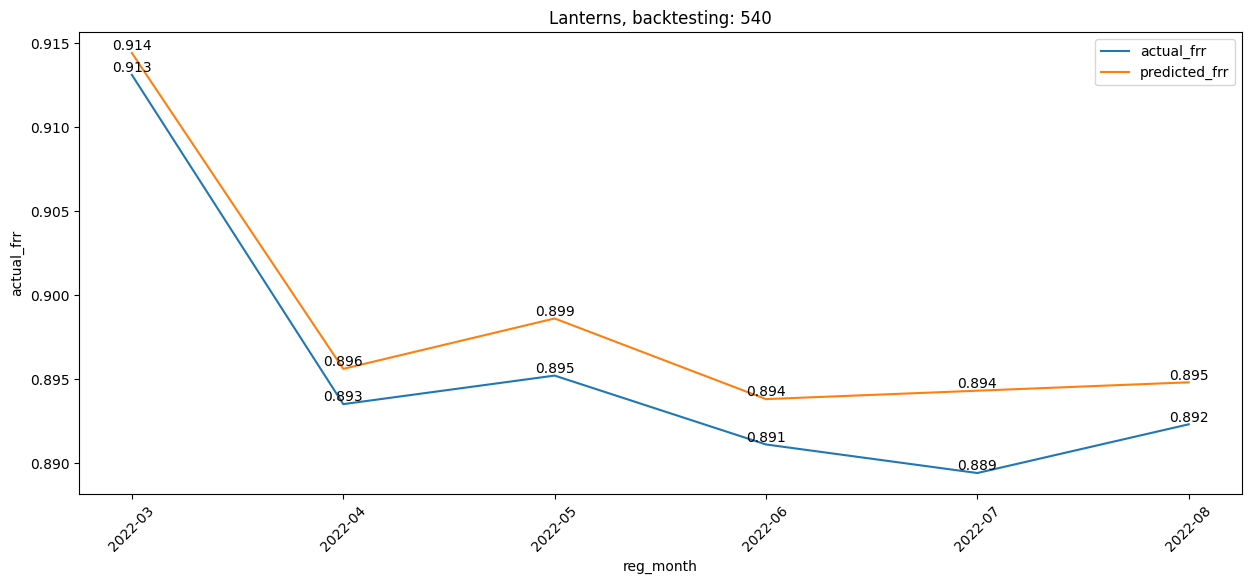

0.0022


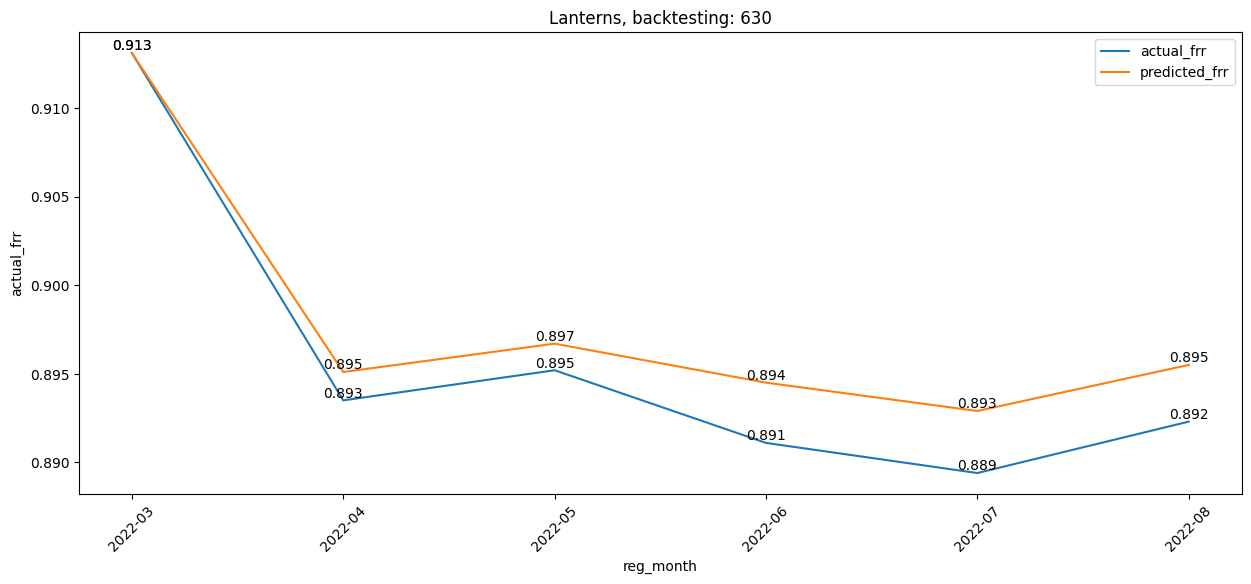

0.0083


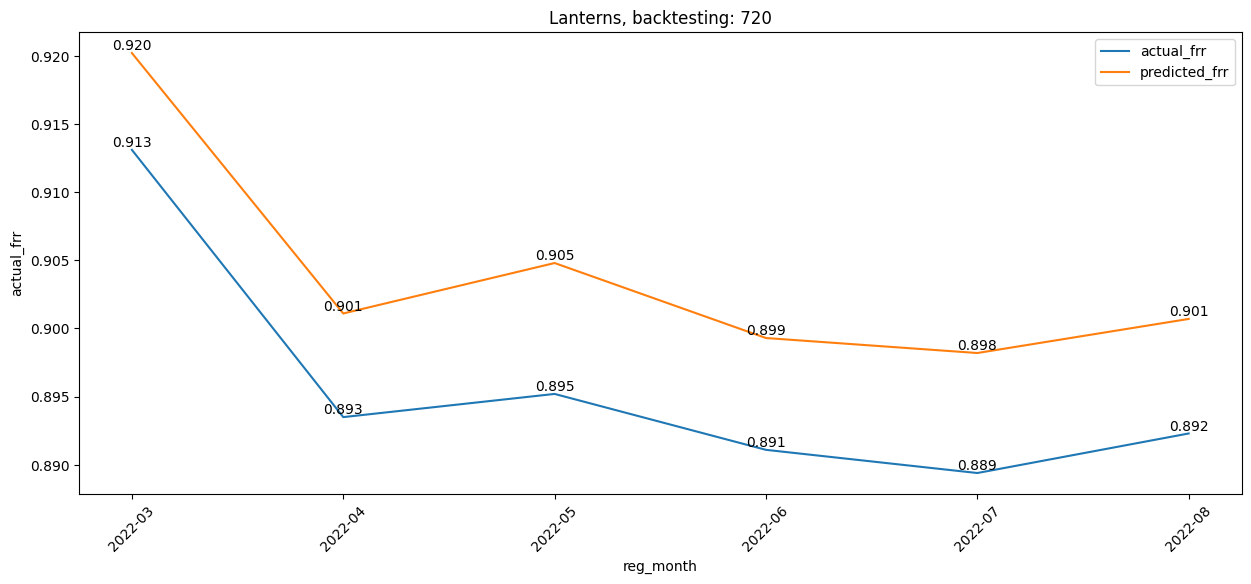

-0.0047


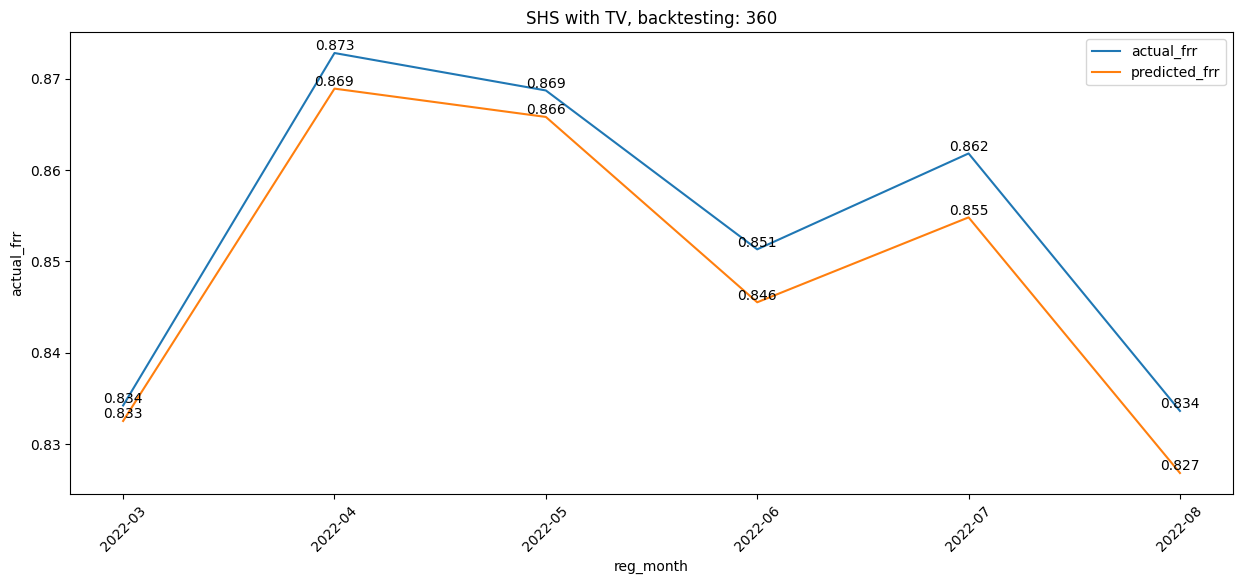

-0.0064


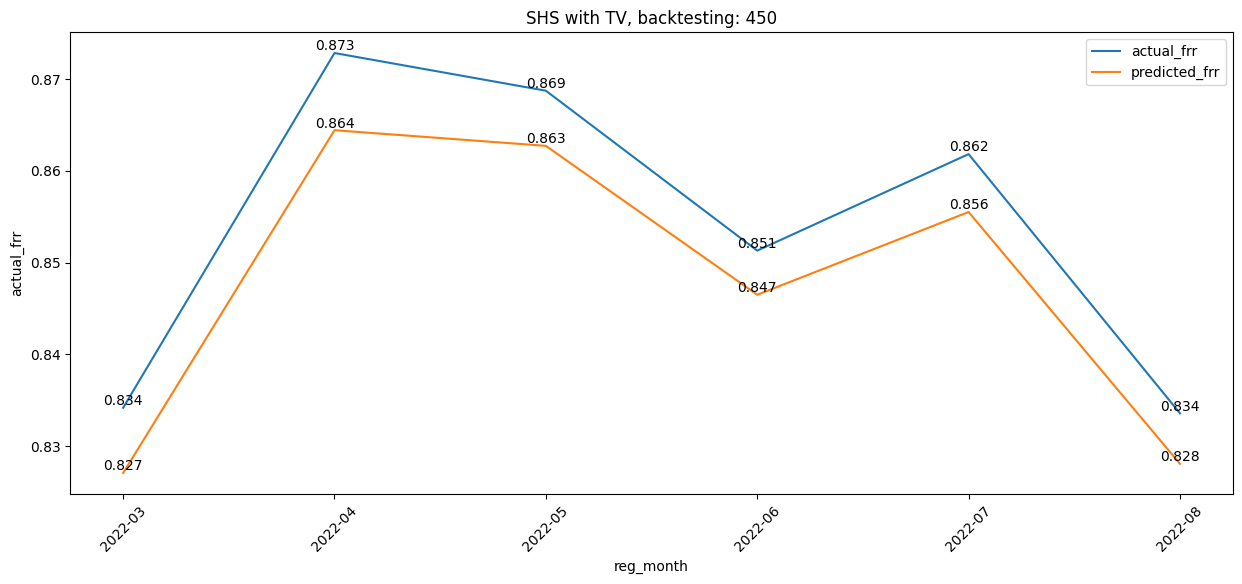

0.0013


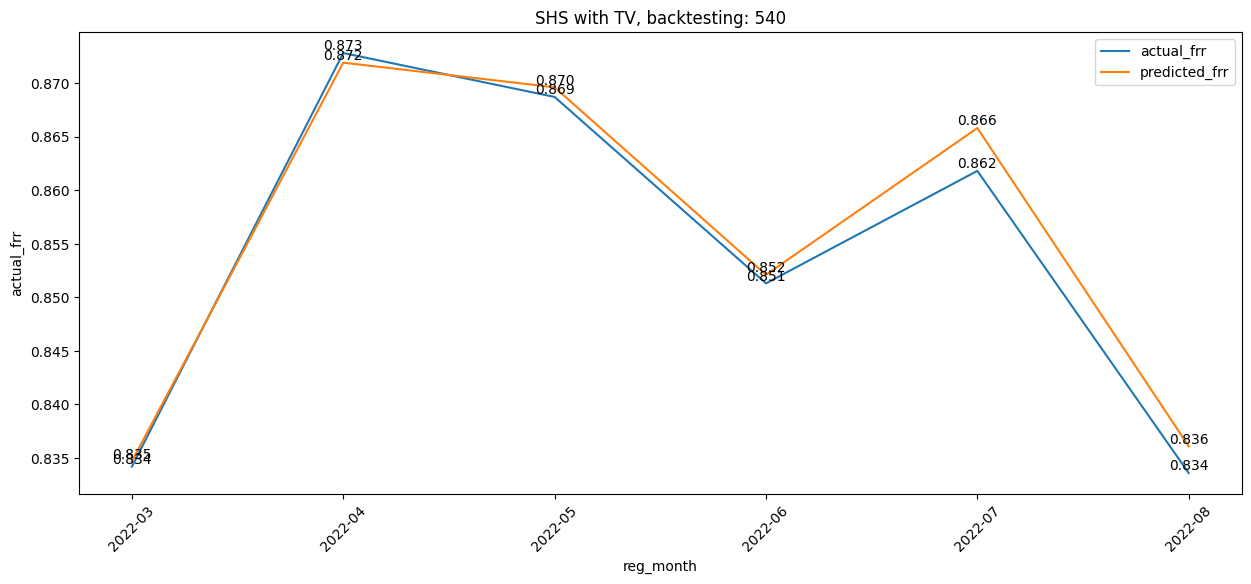

0.0021


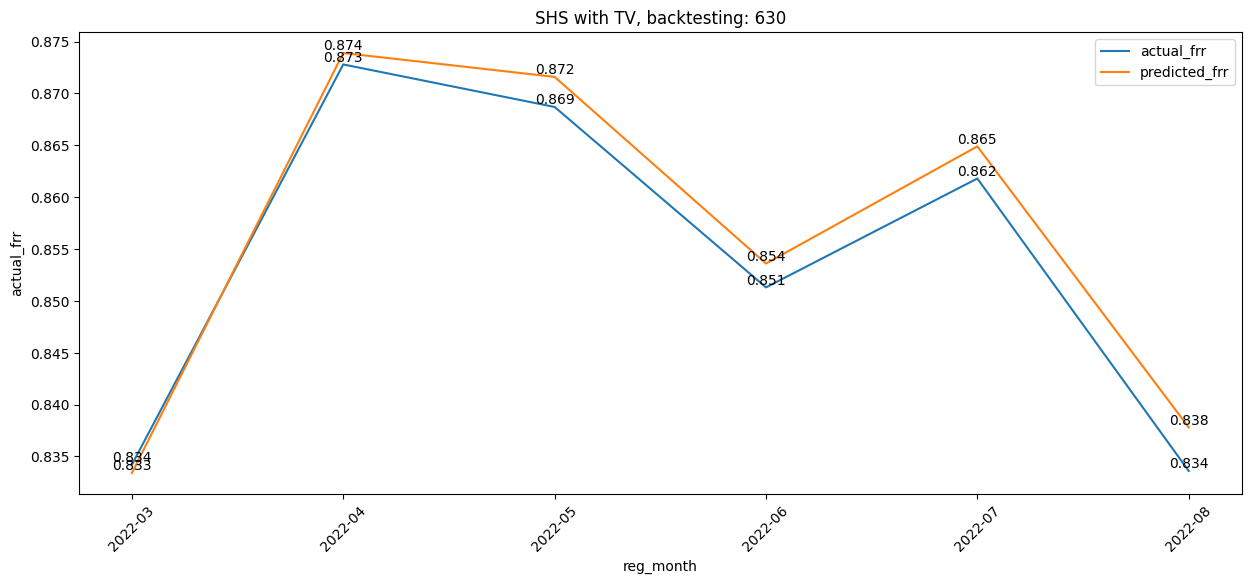

-0.002


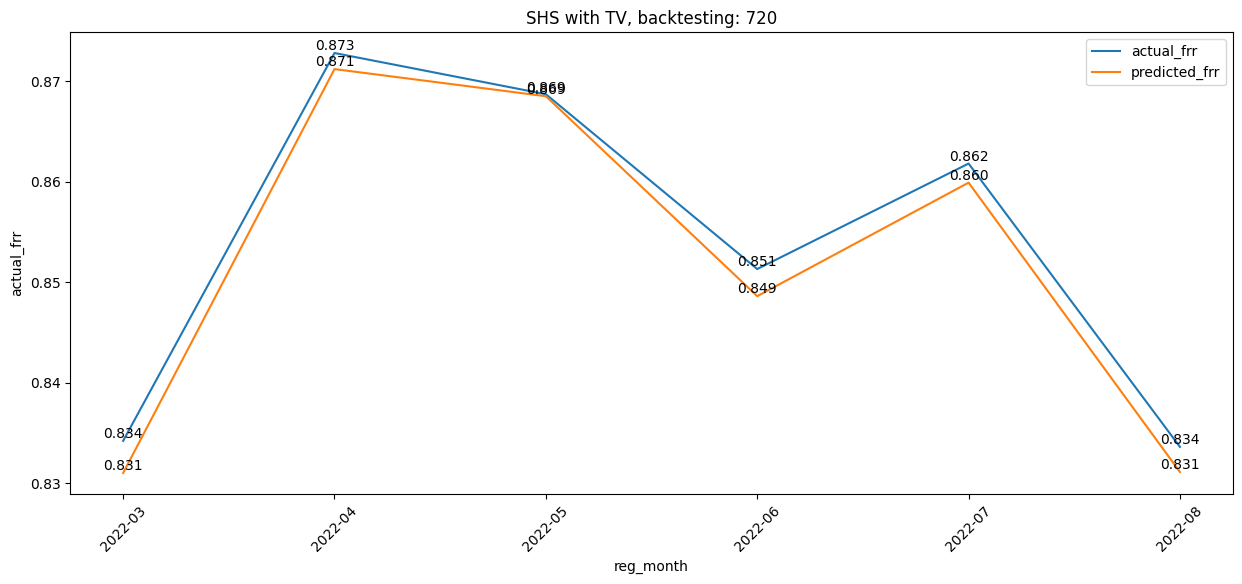

-0.0111


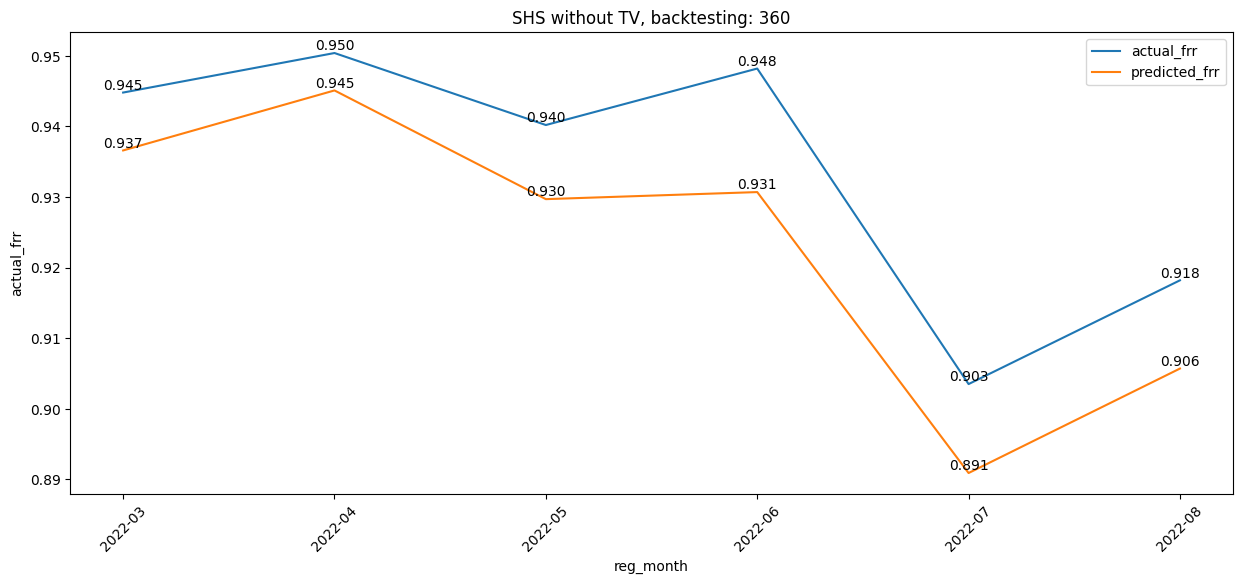

-0.0172


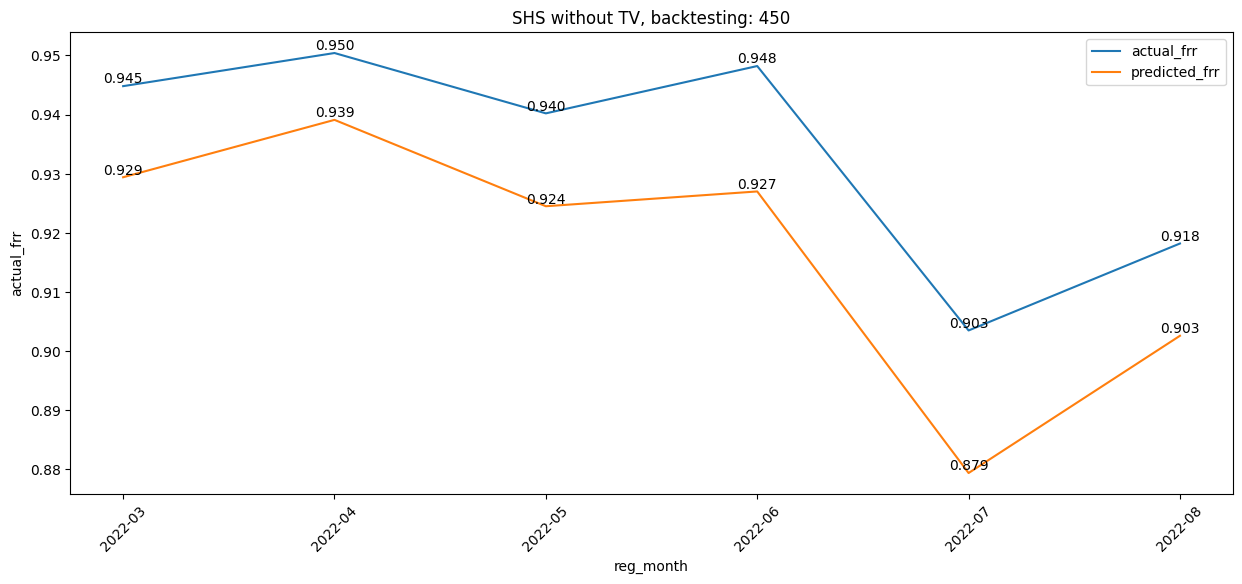

-0.0154


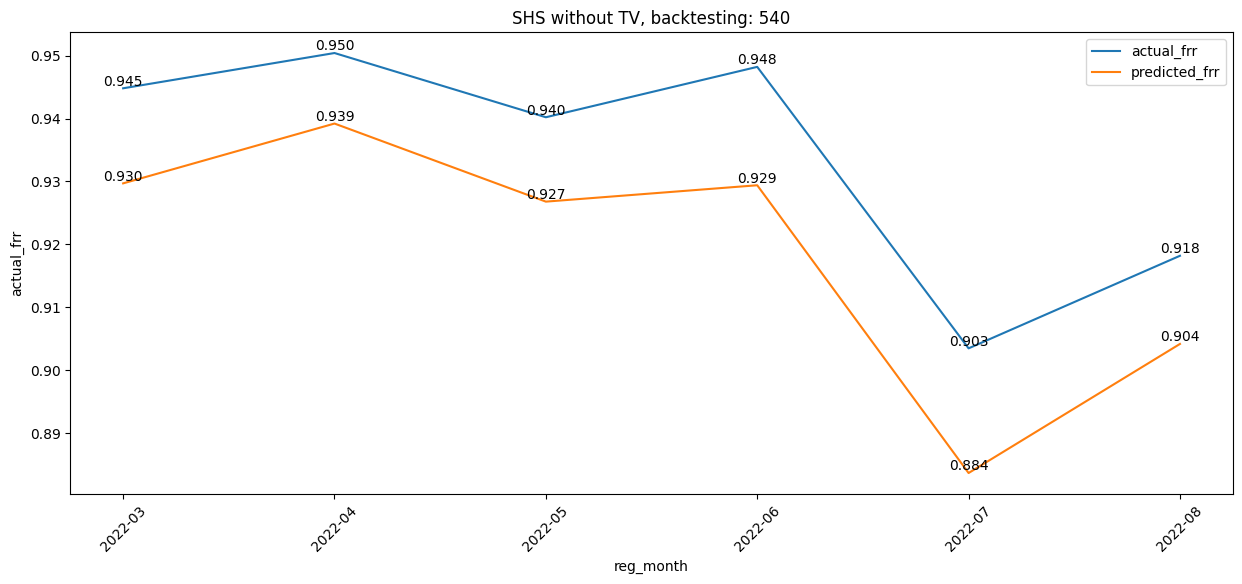

-0.0104


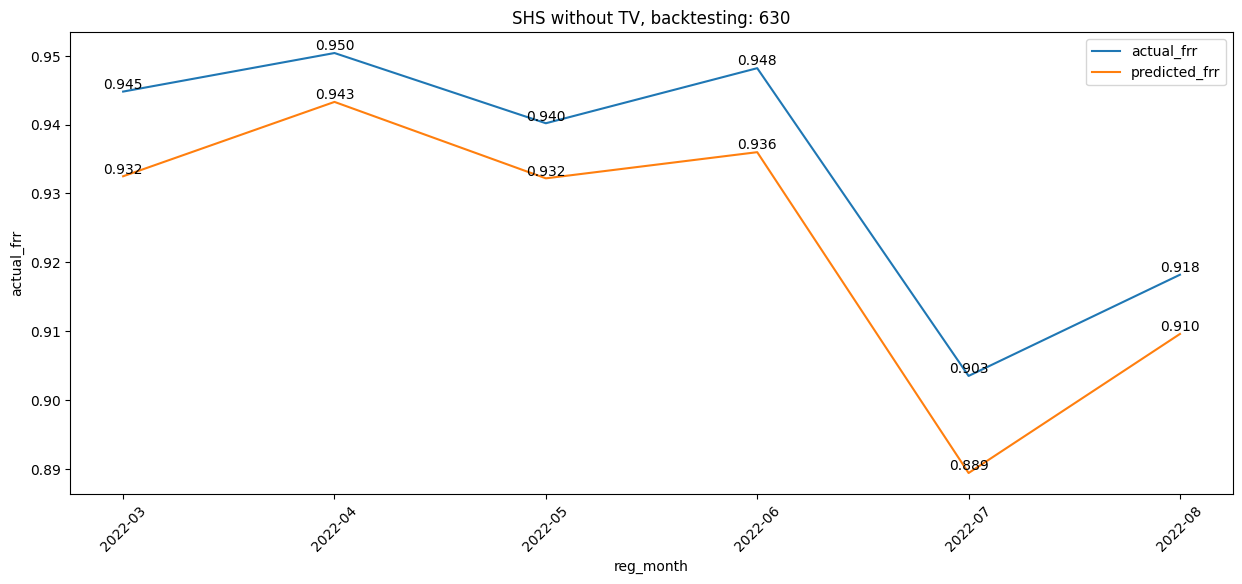

-0.007


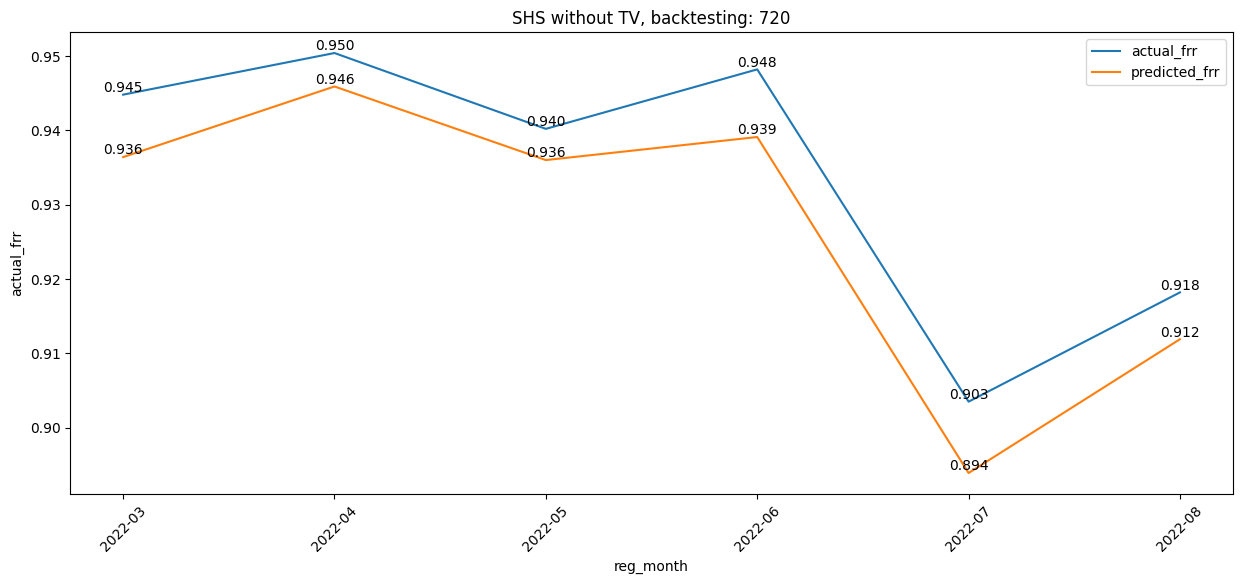

0.0019


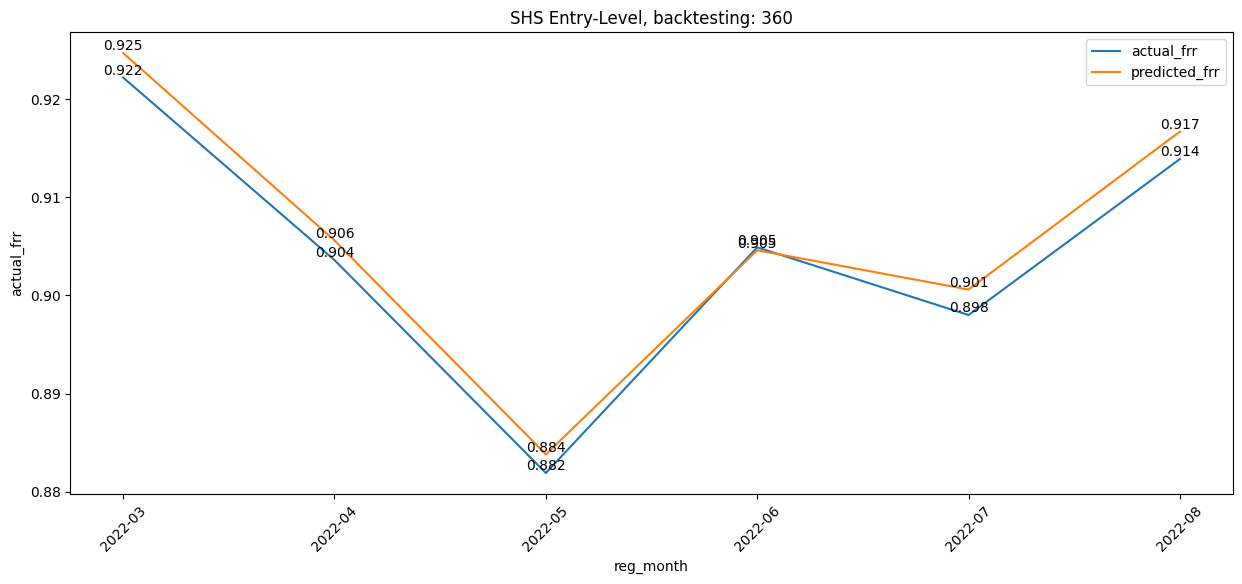

0.0017


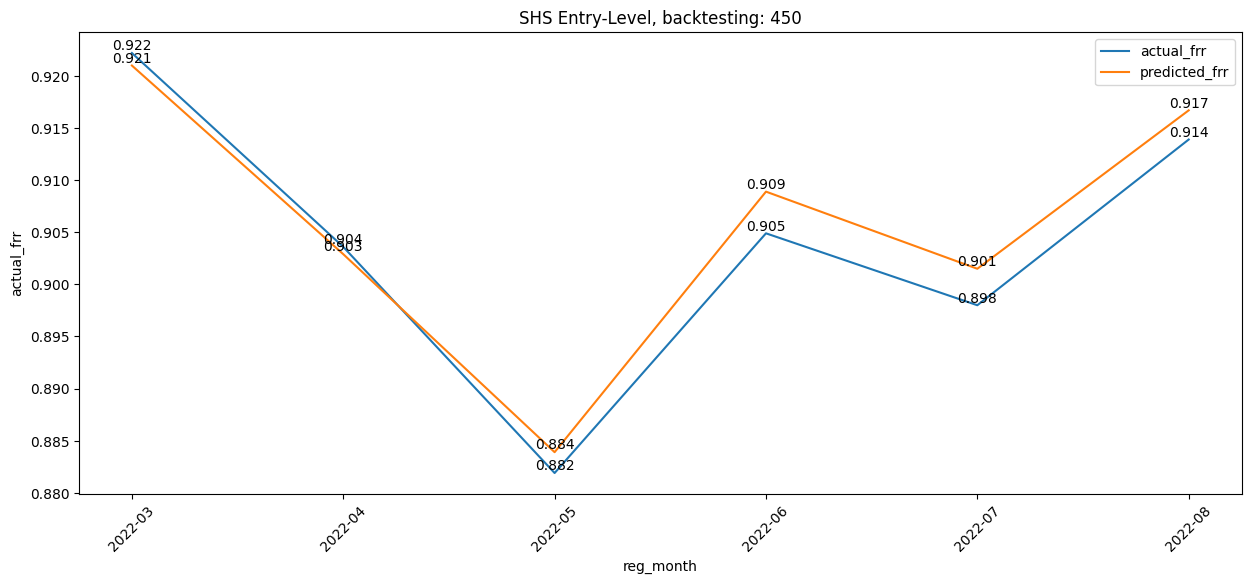

0.0027


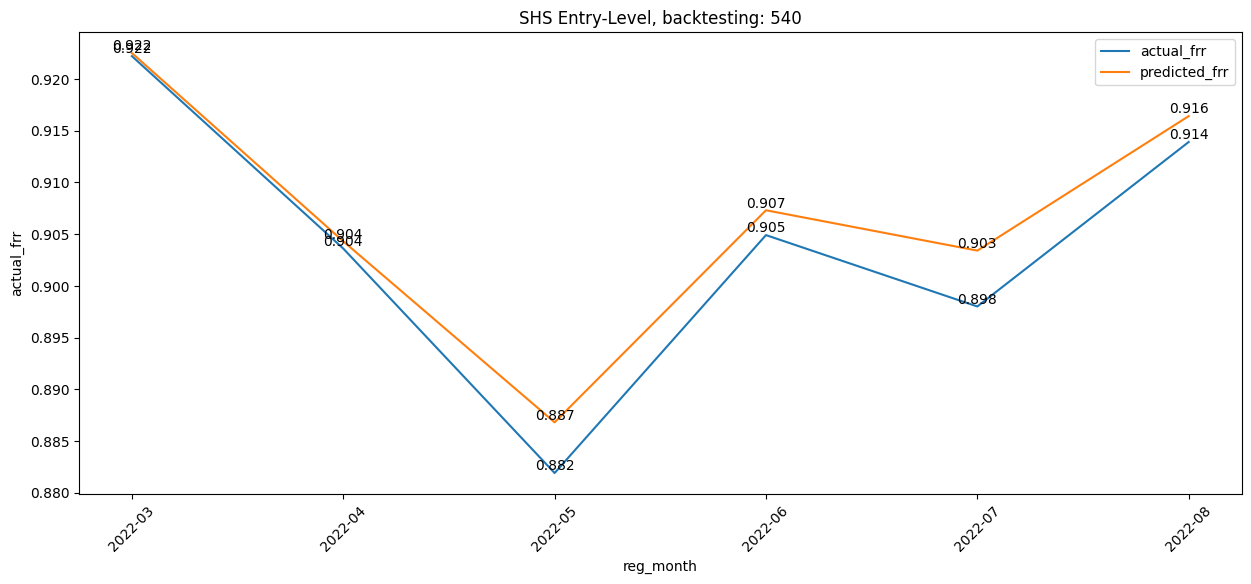

0.0021


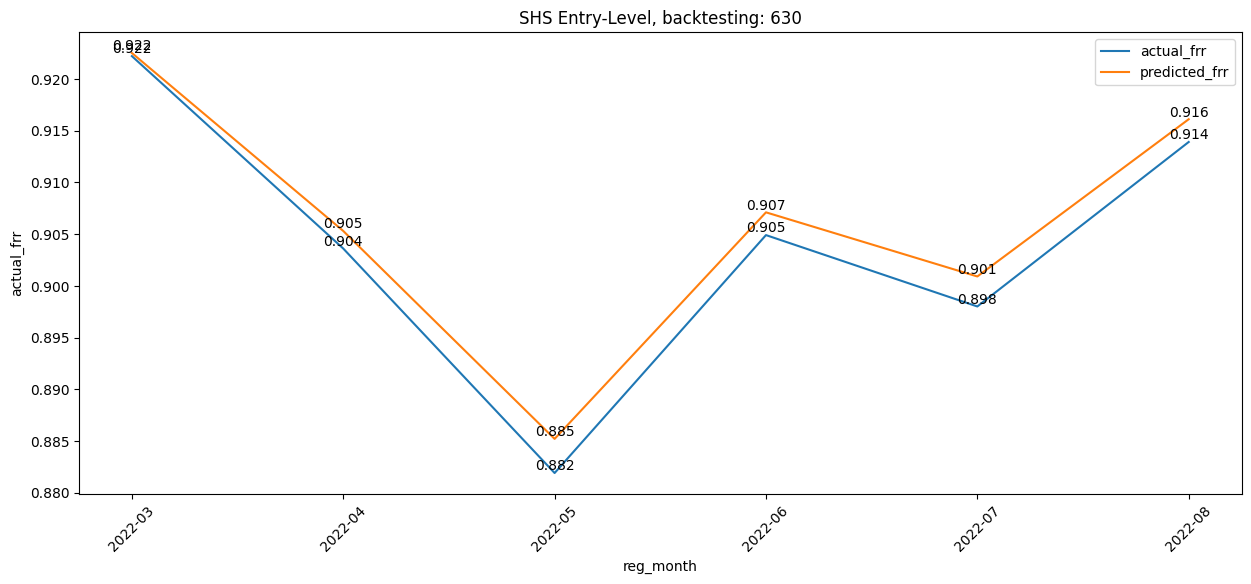

0.001


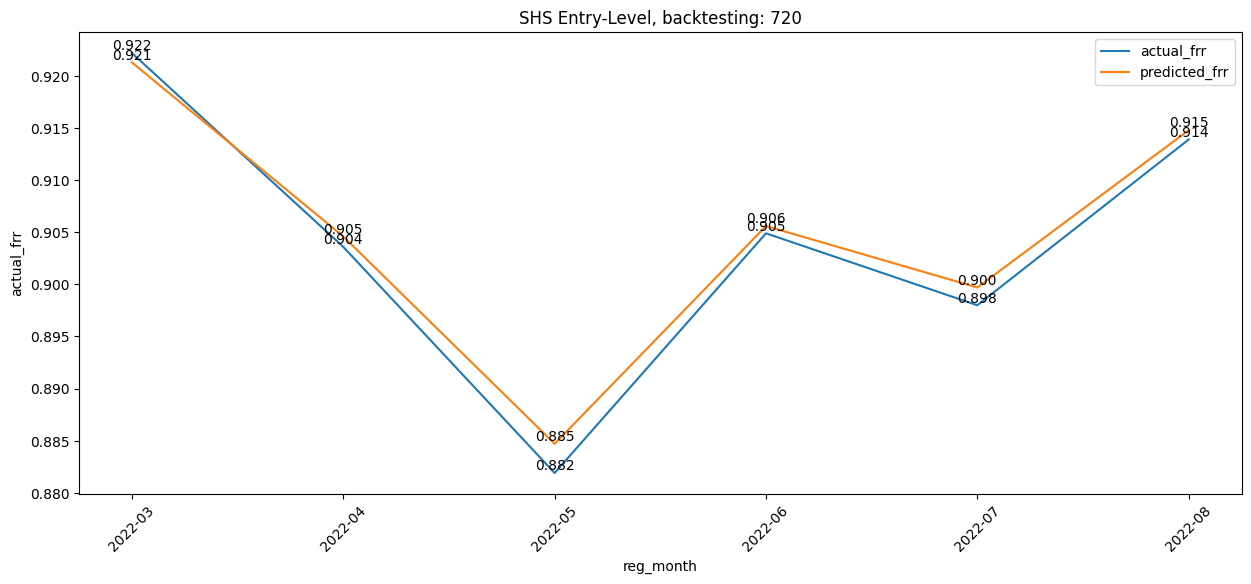

In [24]:
for product_group in product_list:
    for backtesting in list_backtesting:
        plt.figure(figsize=(15, 6))
        subset = df_product[(df_product.product_group==product_group) & (df_product.backtesting==backtesting)]
        deviation = (subset.predicted_frr - subset.actual_frr).mean().round(4)
        print(deviation)
        ax = sns.lineplot(data=subset, x="reg_month", y="actual_frr", label="actual_frr")
        for x, y in zip(subset["reg_month"], subset["actual_frr"]):
            ax.text(x, y, f"{y:.3f}", ha="center", va="bottom")
        
        ax = sns.lineplot(data=subset, x="reg_month", y="predicted_frr", label="predicted_frr")
        for x, y in zip(subset["reg_month"], subset["predicted_frr"]):
            ax.text(x, y, f"{y:.3f}", ha="center", va="bottom")
        # sns.lineplot(data=df2, x="reg_month", y="frr_prediction_50")
        plt.xticks(rotation=45)
        plt.title(f"{product_group}, backtesting: {backtesting}")
        plt.legend()
        plt.show()